# Comparative Analysis of Deep Learning Architectures for Earthquake Prediction

**AI7102: Introduction to Deep Learning - Project Proposal - Fall 2025**

**Team Members:** Mohamed Alrayssi, Majid Ibrahim, Hamdan Almehairbi, Mohammed Ibrahim Alblooshi

---
### Important Workflow

This project is split into three main parts:

1. **`prepare_dataset.py`**: Pre-processes all data and saves loaders.

2. **`experiment.py`**: Runs the optimizer comparison and generates `training_histories.json`.

3. **`analysis_notebook.ipynb`**: Loads `training_histories.json` to visualize results and analyze the best models.



To run this project correctly, you must first execute the experiment script from your terminal:



```bash

python experiment.py

```



After the script finishes, you can run the cells in this notebook to analyze the generated results.


## 1. Setup and Environment


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.auto import tqdm
from scipy.stats import ks_2samp

# Import our project modules
import utils
import data_loader
import models # To load model architecture for error analysis

# Configure plotting style
utils.setup_plotting_style()


Plotting style configured.


## 2. Data Loading and Exploratory Analysis (EDA)

In [12]:
DATA_PATH = 'data/train.csv' # Assumes train.csv is in a /data subfolder
train_df = data_loader.load_data(DATA_PATH, nrows=60_000_000)
display(train_df.head())


Loaded 60,000,000 rows from data/train.csv


acoustic_data  time_to_failure
0             12           1.4691
1              6           1.4691
2              8           1.4691
3              5           1.4691
4              8           1.4691

Visualizing a sample of the raw time-series data:


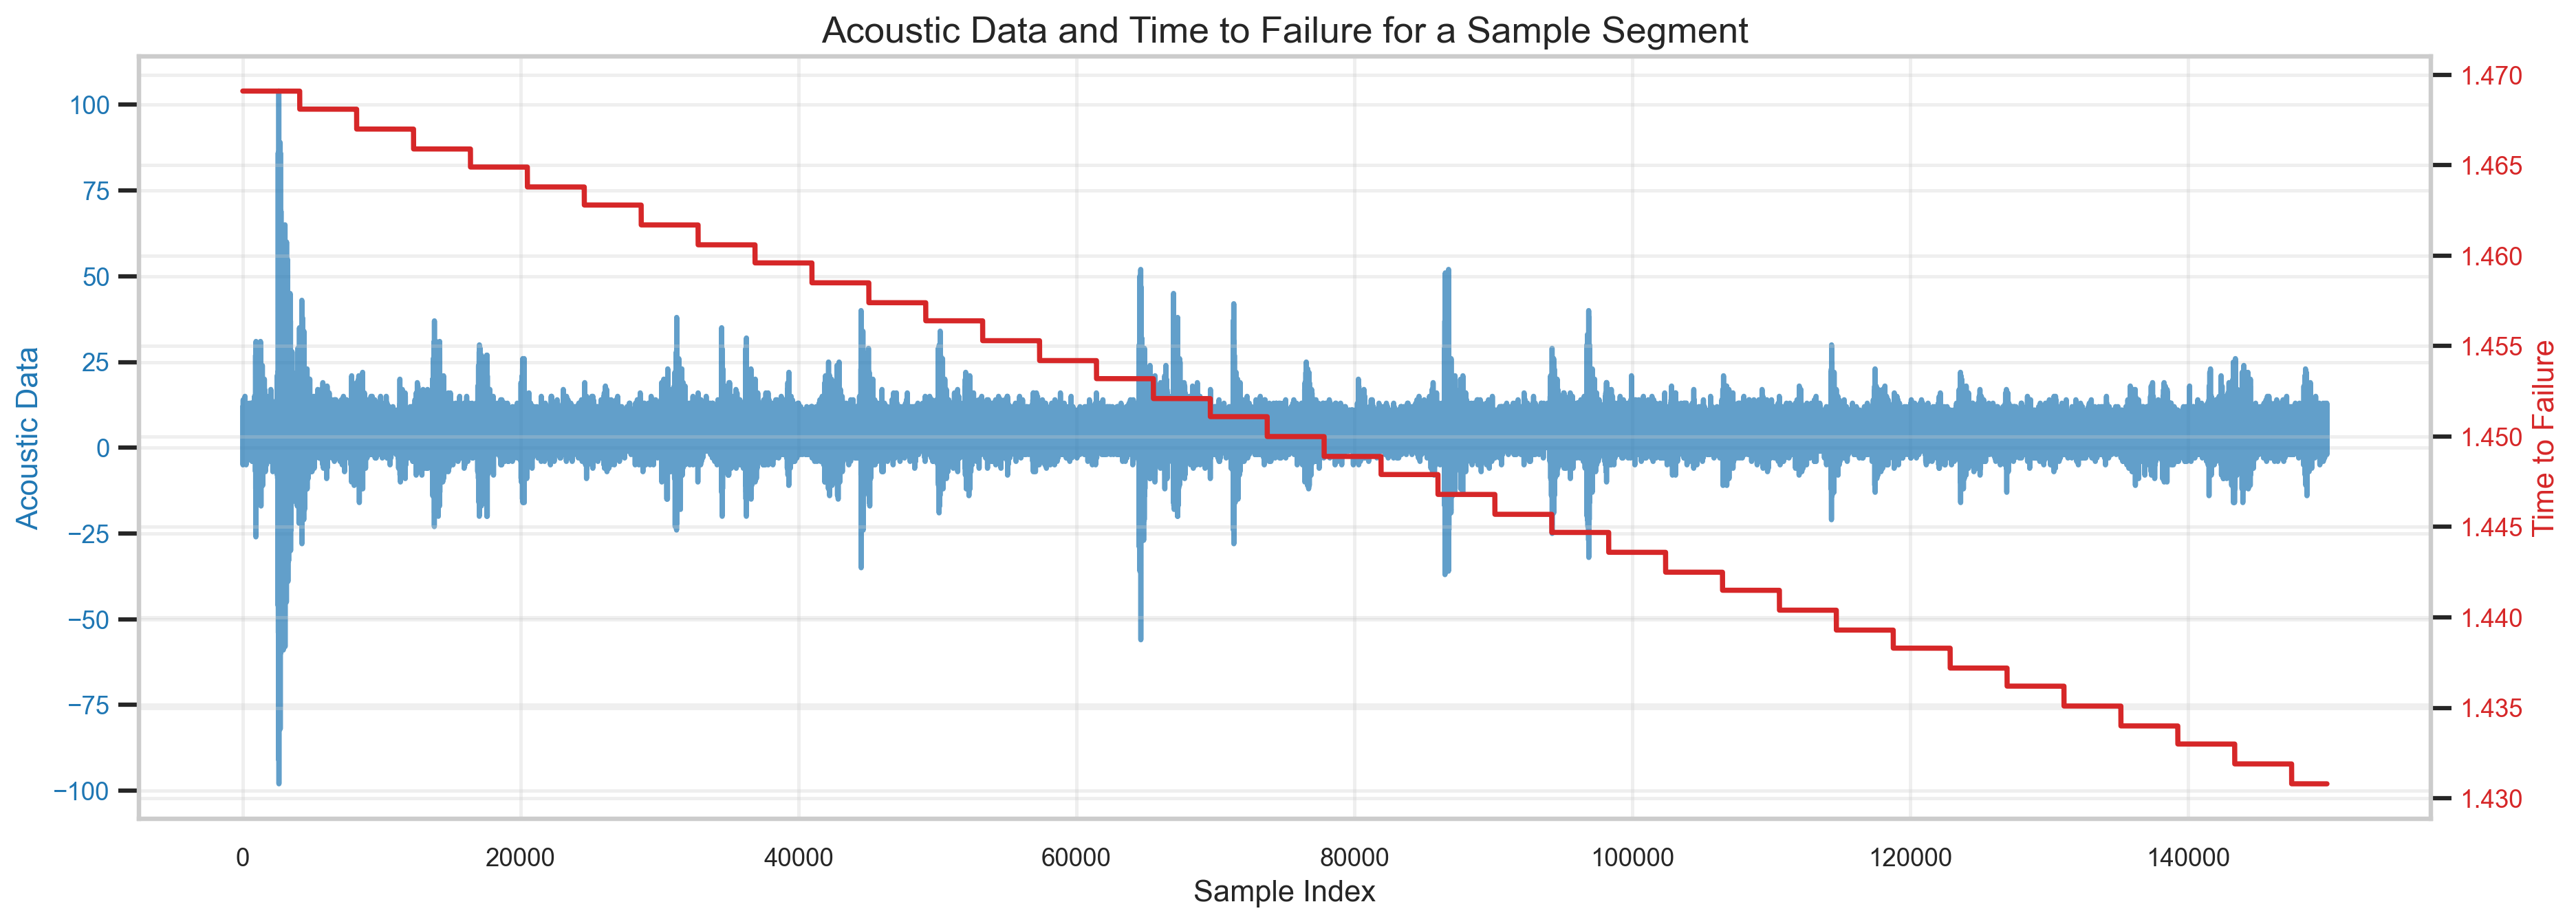

In [13]:
print("Visualizing a sample of the raw time-series data:")
data_loader.plot_eda_segment(train_df)


### Target Variable Distribution

This histogram shows the distribution of the final `time_to_failure` value for each 150,000-sample segment in the training data. The distribution is right-skewed, indicating that shorter times to failure are more common than very long ones. This is a critical characteristic for the model to learn.


Segmenting for Histogram:   0%|          | 0/400 [00:00<?, ?it/s]

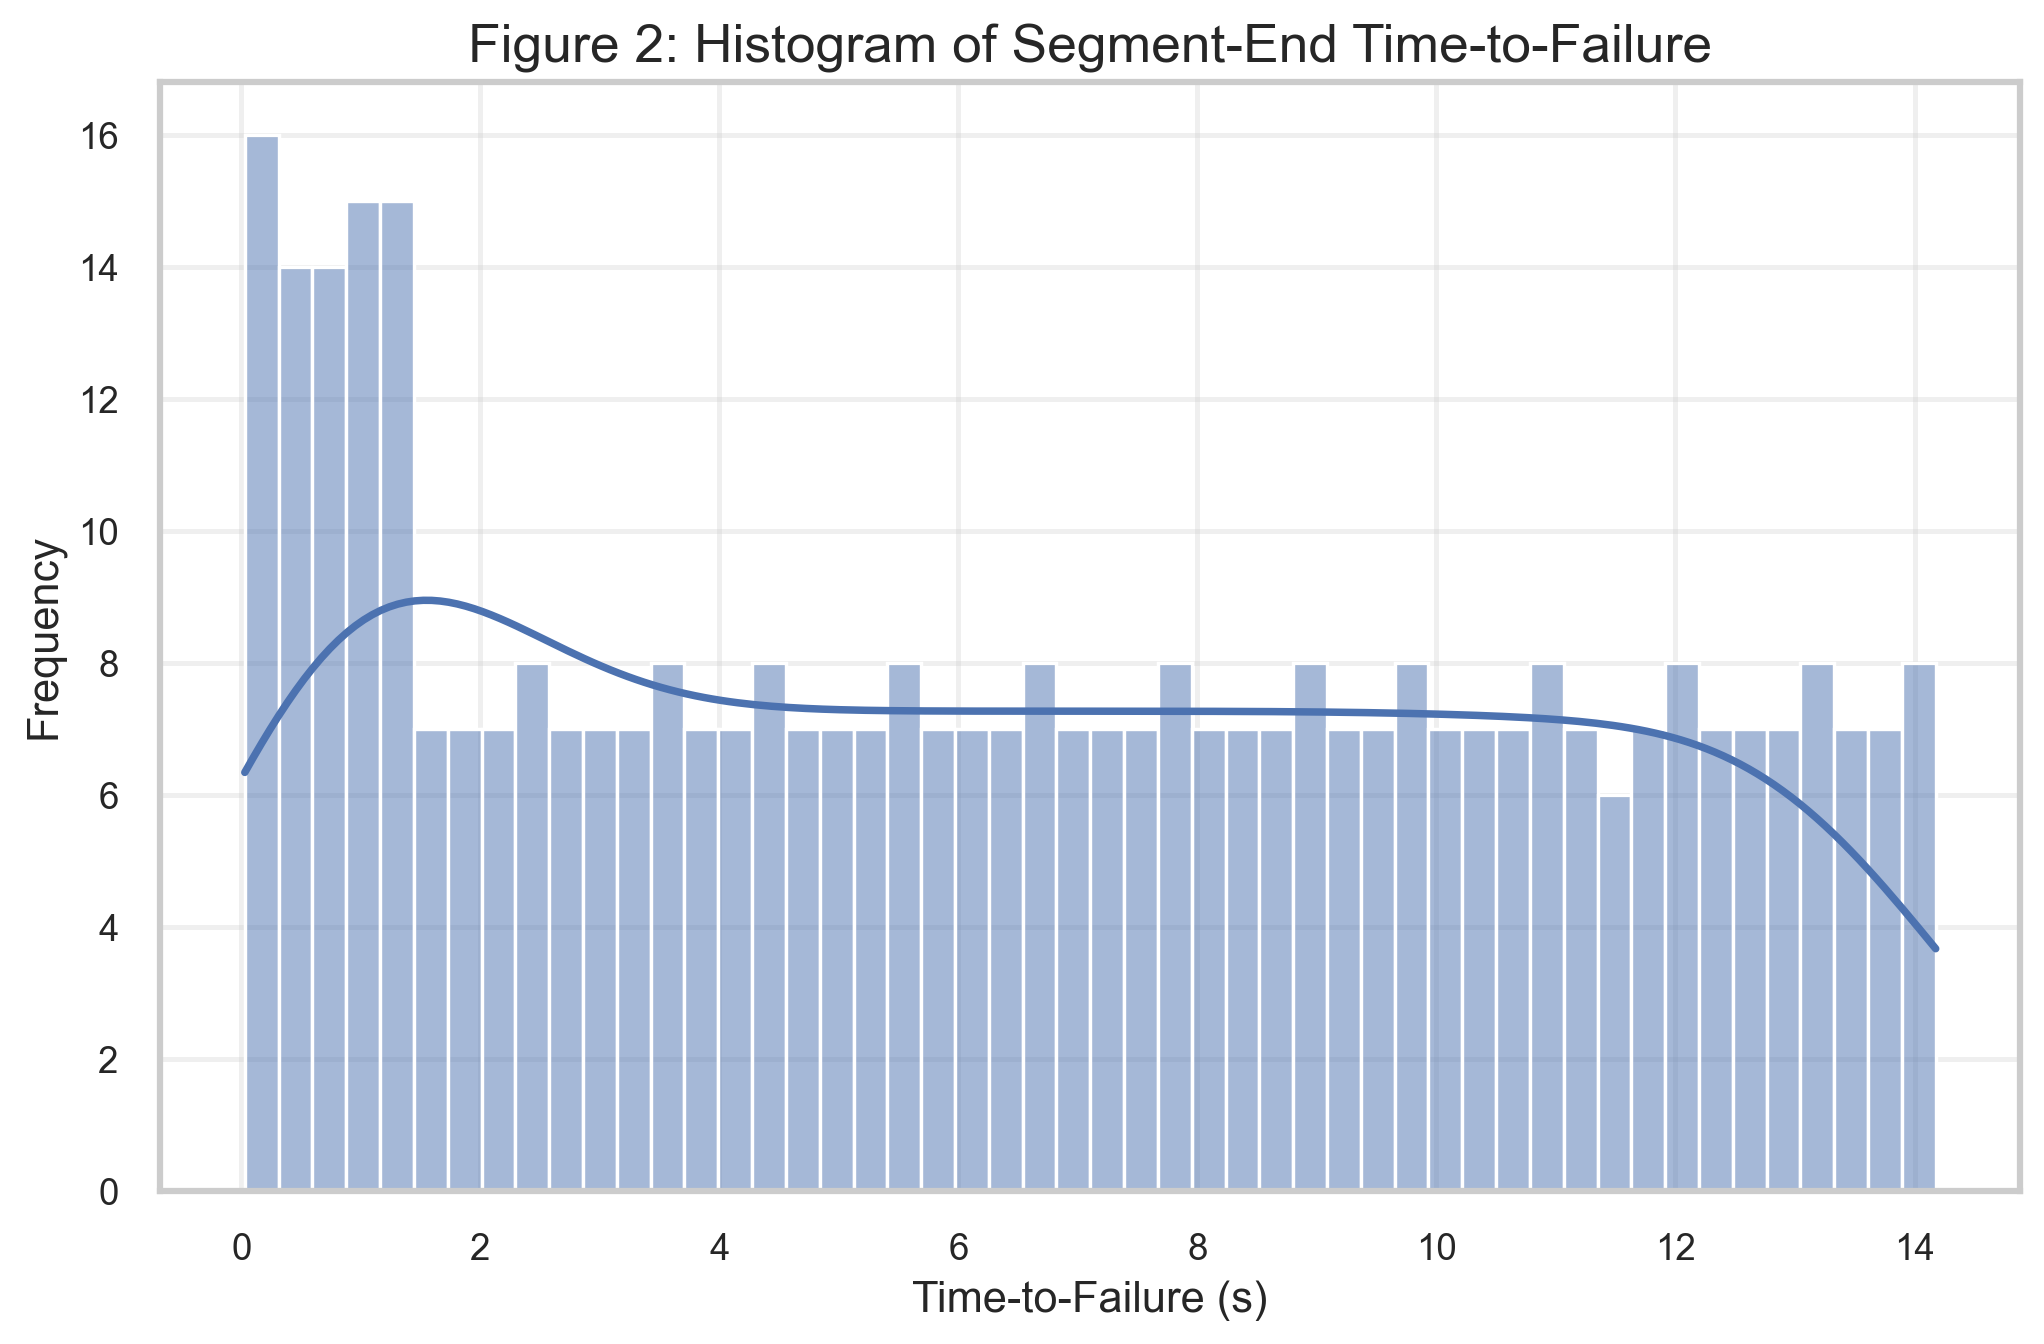

In [14]:
# Calculate the final time_to_failure for each segment
rows = 150_000
segments = len(train_df) // rows
y_train_hist = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

for idx in tqdm(range(segments), desc="Segmenting for Histogram"):
    seg = train_df.iloc[idx*rows : idx*rows + rows]
    y_train_hist.loc[idx, 'time_to_failure'] = seg['time_to_failure'].values[-1]

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(y_train_hist['time_to_failure'], bins=50, kde=True)
plt.xlabel('Time-to-Failure (s)')
plt.ylabel('Frequency')
plt.title('Figure 2: Histogram of Segment-End Time-to-Failure')
plt.show()


## 2a. Feature Exploration: Rolling Statistics

Before building complex features, we can explore simple transformations. This plot shows a rolling standard deviation of the acoustic signal. Smoothing the noisy raw signal this way helps reveal underlying patterns that correlate with the sawtooth shape of the `time_to_failure` signal. This motivates our more comprehensive feature engineering approach.


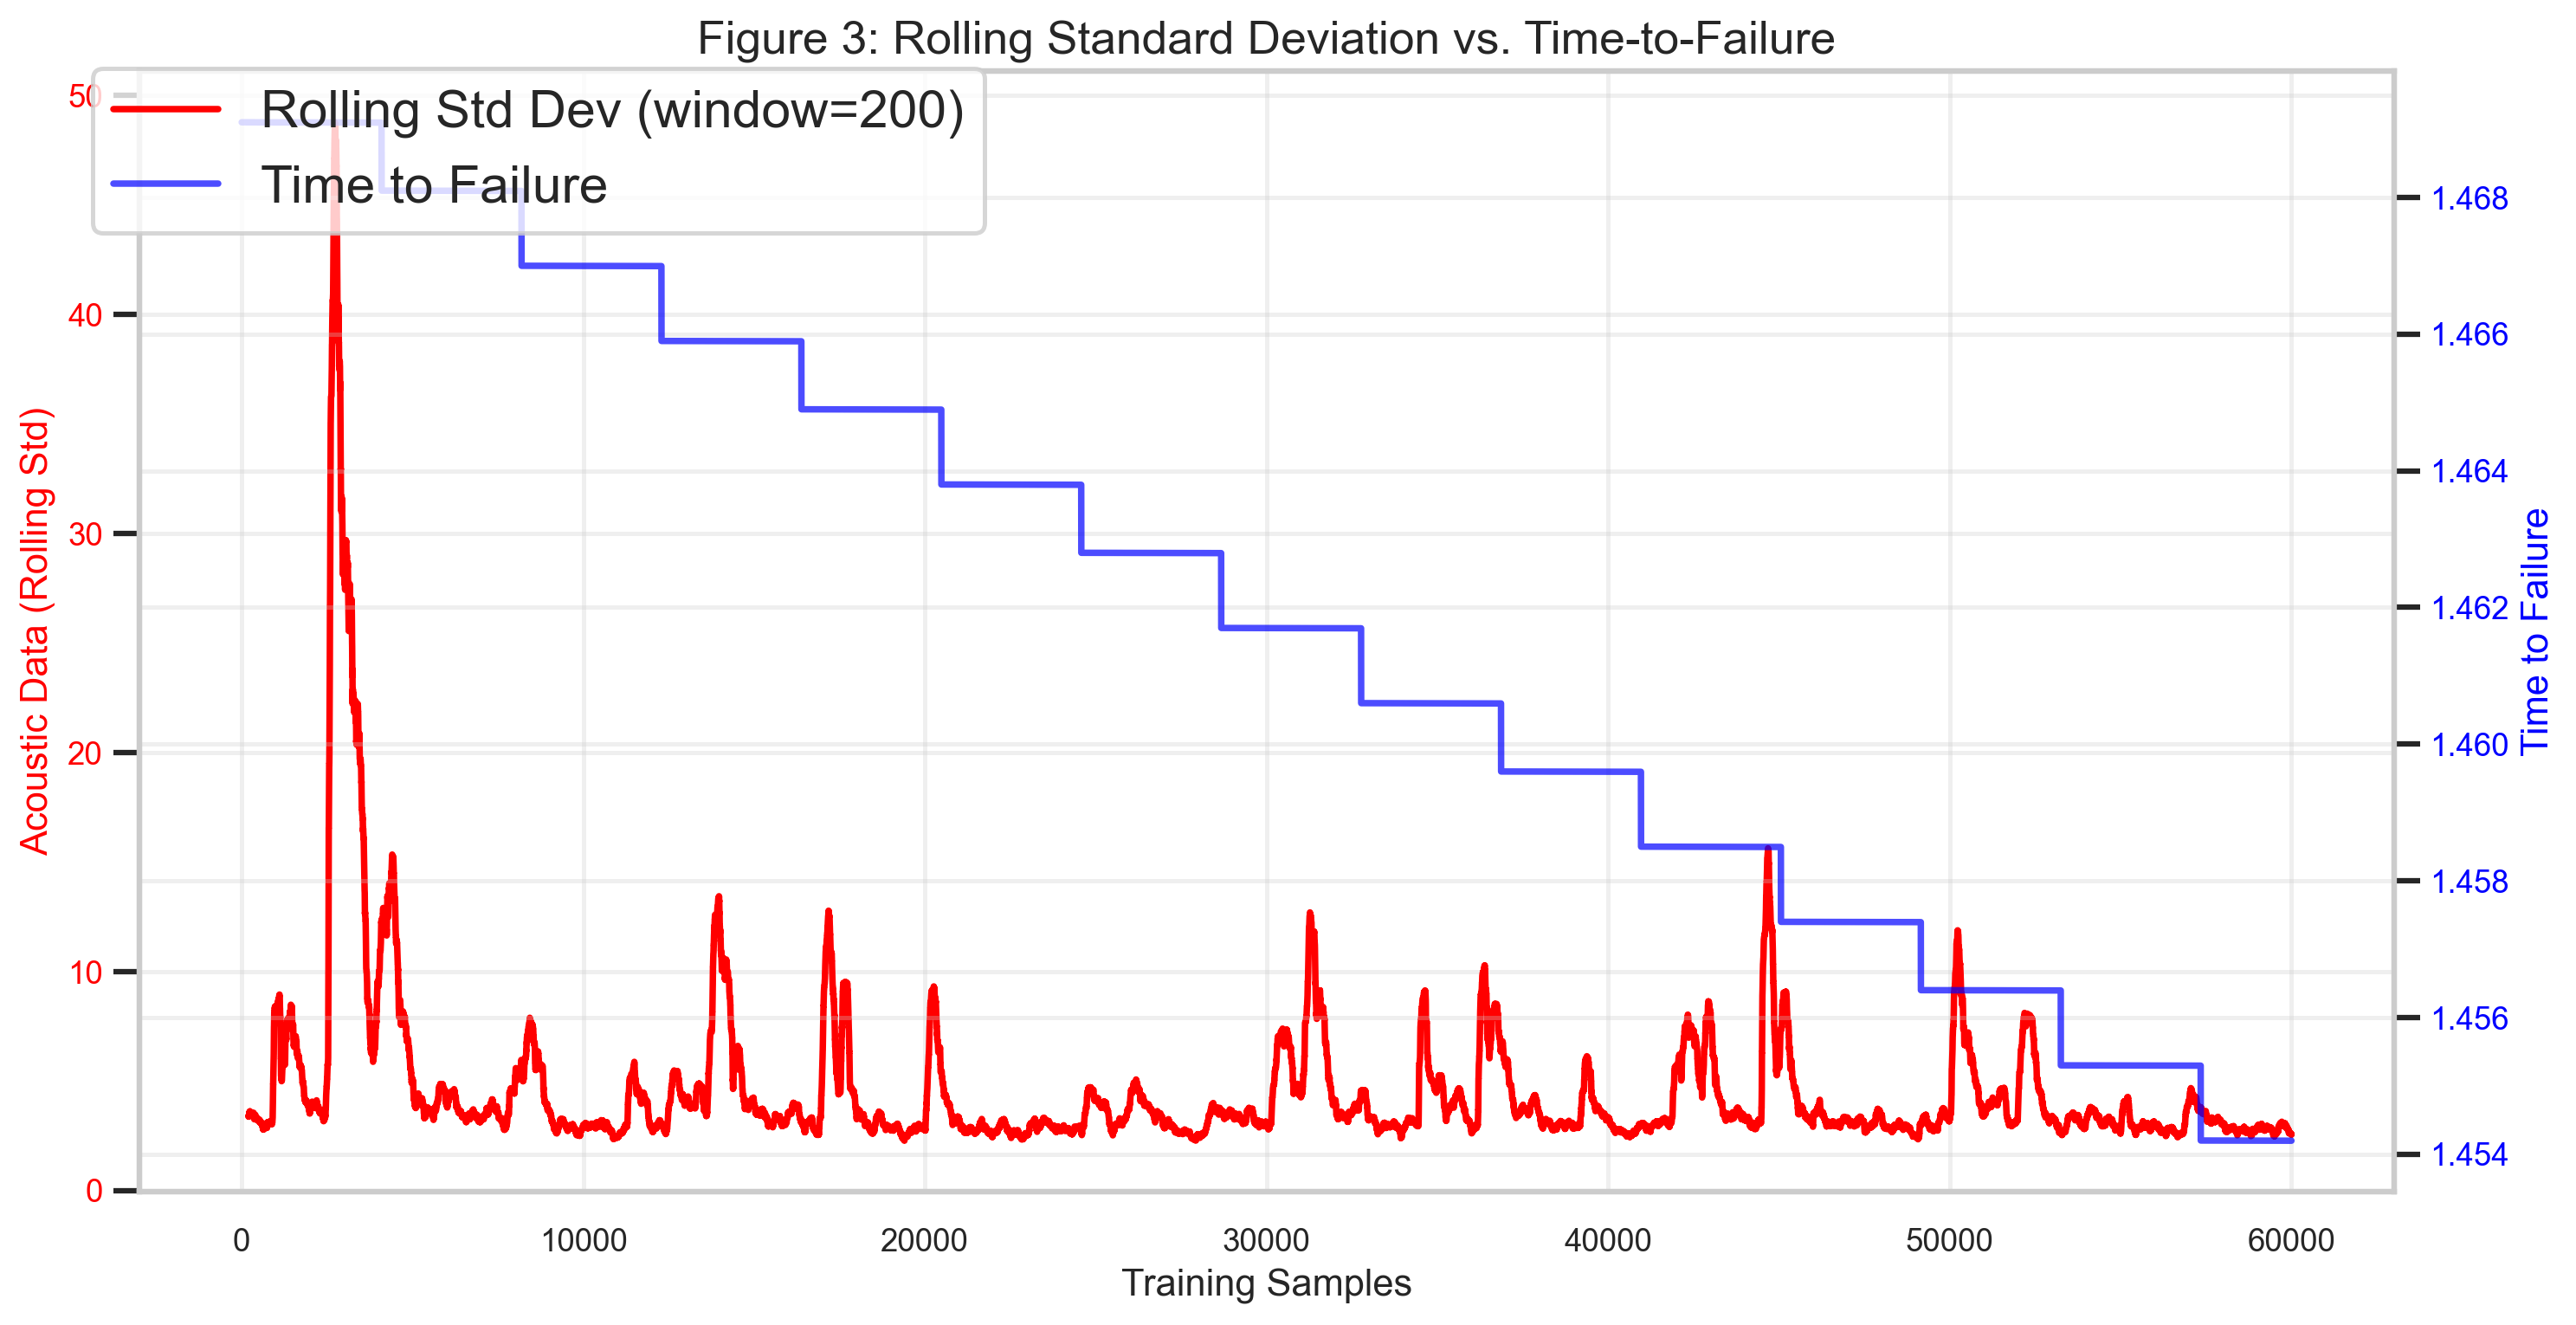

In [15]:
# Use a smaller slice of the data for performance
train_sample = train_df.iloc[:60000].copy()

# Calculate rolling standard deviation
window = 200
roll_std = train_sample['acoustic_data'].rolling(window=window).std().dropna()

fig, ax1 = plt.subplots(figsize=(14, 7))
plt.title('Figure 3: Rolling Standard Deviation vs. Time-to-Failure')

# Plot the rolling feature
ax1.plot(roll_std.index, roll_std.values, color='red', label='Rolling Std Dev (window=200)')
ax1.set_xlabel('Training Samples')
ax1.set_ylabel('Acoustic Data (Rolling Std)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Plot the time to failure on a second y-axis
ax2 = ax1.twinx()
ax2.plot(train_sample.index, train_sample['time_to_failure'], color='blue', alpha=0.7, label='Time to Failure')
ax2.set_ylabel('Time to Failure', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


## 3. Feature Importance Analysis

Before diving into model results, let's understand which engineered features are most predictive using a simple linear model and permutation importance. This tells us what signal characteristics are most valuable.


Loading data for feature importance analysis...
Loaded 30,000,000 rows from data\train.csv
Preparing features...
Starting data preparation: Engineering features into sequences...


  0%|          | 0/200 [00:00<?, ?it/s]


Final data shape for temporal models: Train=(160, 10, 15), Val=(40, 10, 15)
Extracting data from loaders (features: 15)...
Data shape: (160, 10, 15), Labels shape: (160, 1)
Training Ridge regression model...
Computing permutation importance (this may take a few minutes)...


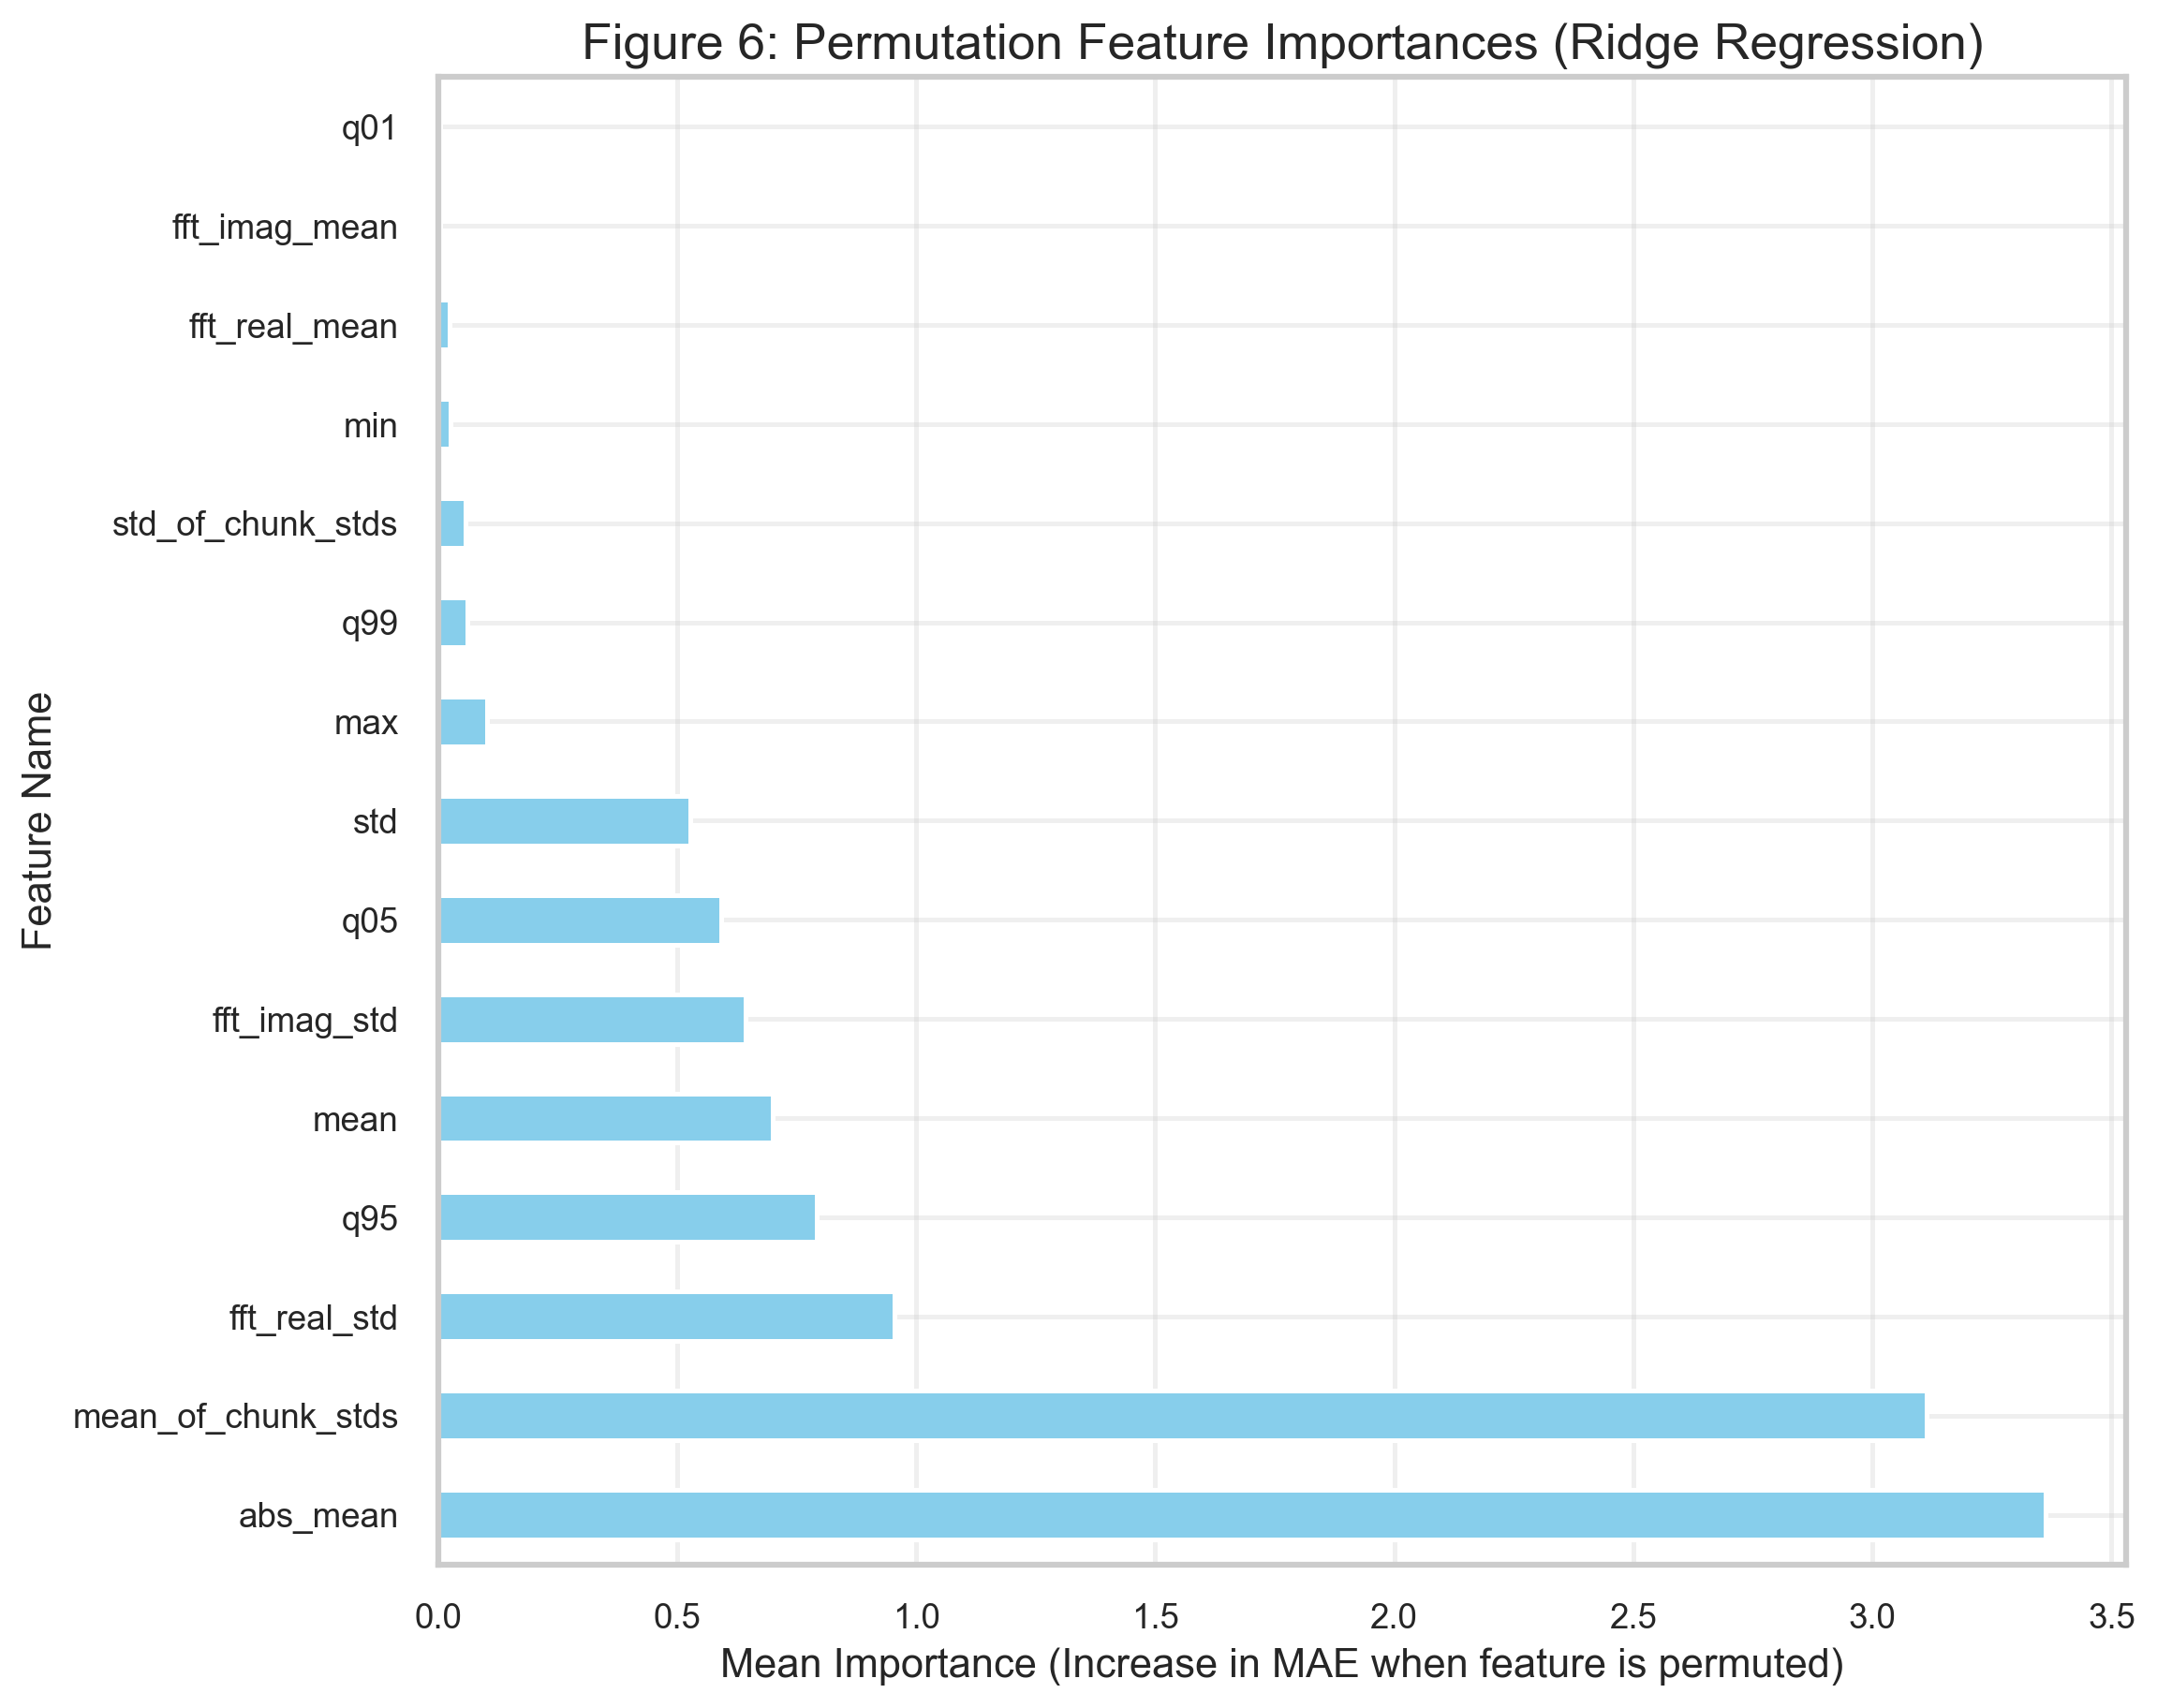


Top 10 Most Important Features:
abs_mean              3.362634
mean_of_chunk_stds    3.112924
fft_real_std          0.954159
q95                   0.791995
mean                  0.699609
fft_imag_std          0.643802
q05                   0.591841
std                   0.527081
max                   0.102242
q99                   0.061746
dtype: float64


In [16]:
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance
import data_pipeline
import config

try:
    print("Loading data for feature importance analysis...")
    # Load a sample of the data for feature importance (can be memory intensive)
    # Using a subset for efficiency - increase if you have more memory
    df_sample = data_loader.load_data(config.TRAIN_DATA_PATH, nrows=30_000_000)
    
    print("Preparing features...")
    # Prepare data to get feature names and processed data
    train_loader_fi, val_loader_fi, num_features, feature_names, scaler = data_pipeline.prepare_data(
        df_sample,
        main_segment_size=config.MAIN_SEGMENT_SIZE,
        sub_segment_size=config.SUB_SEGMENT_SIZE,
        test_size=config.TEST_SIZE
    )
    
    print(f"Extracting data from loaders (features: {num_features})...")
    # Extract data from loaders for analysis
    X_train_list, y_train_list = [], []
    for Xb, yb in train_loader_fi:
        X_train_list.append(Xb.numpy())
        y_train_list.append(yb.numpy())
    
    X_train_s = np.concatenate(X_train_list, axis=0)
    y_train_s = np.concatenate(y_train_list, axis=0)
    
    print(f"Data shape: {X_train_s.shape}, Labels shape: {y_train_s.shape}")
    
    # Flatten data for linear model (each timestep gets the same label)
    # This is a simplification - in practice, you might want to use only the last timestep
    X_train_flat = X_train_s.reshape(-1, X_train_s.shape[-1])
    y_train_flat = np.repeat(y_train_s, X_train_s.shape[1])

    print("Training Ridge regression model...")
    linear_model = Ridge(alpha=1.0).fit(X_train_flat, y_train_flat)
    
    print("Computing permutation importance (this may take a few minutes)...")
    # Use a smaller sample for permutation importance to speed up computation
    sample_size = min(10000, len(X_train_flat))
    sample_indices = np.random.choice(len(X_train_flat), sample_size, replace=False)
    X_sample = X_train_flat[sample_indices]
    y_sample = y_train_flat[sample_indices]
    
    result = permutation_importance(
        linear_model, X_sample, y_sample, 
        n_repeats=5, random_state=42, n_jobs=-1, scoring='neg_mean_absolute_error'
    )
    
    importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 8))
    importances.plot(kind='barh', color='skyblue')
    plt.title('Figure 6: Permutation Feature Importances (Ridge Regression)')
    plt.xlabel('Mean Importance (Increase in MAE when feature is permuted)')
    plt.ylabel('Feature Name')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(importances.head(10))

except Exception as e:
    print(f"Feature importance analysis skipped: {e}")
    import traceback
    traceback.print_exc()


## 4. Optimizer Experiment Results

The optimizer comparison experiment (`experiment.py`) trains all models with multiple optimizer configurations and saves the results to `training_histories.json`. This section loads and summarizes those results to identify the best-performing model-optimizer combinations.


In [17]:
# Load experiment results and create a summary DataFrame
import json
import pandas as pd

try:
    with open('training_histories.json', 'r') as f:
        histories = json.load(f)
    
    results_list = []
    # Loop through each model and its optimizer results
    for model_name, optimizers in histories.items():
        for optimizer_name, data in optimizers.items():
            results_list.append({
                'Model': model_name,
                'Optimizer': optimizer_name,
                'Best_Val_MAE': data.get('best_val_mae'),
                'Best_Epoch': data.get('best_epoch')
            })
    
    # Create and sort the DataFrame
    performers_df = pd.DataFrame(results_list)
    performers_df = performers_df.sort_values('Best_Val_MAE').reset_index(drop=True)
    print("Table: Summary of Best Performance per Optimizer")
    display(performers_df)
    
except FileNotFoundError:
    print("training_histories.json not found. Please run 'python experiment.py' first.")
except Exception as e:
    print(f"An error occurred: {e}")


Table: Summary of Best Performance per Optimizer


Model                Optimizer  Best_Val_MAE  Best_Epoch
0      Hybrid w/ Attention  SGD_Momentum_OneCycleLR      2.276890          29
1          Hybrid CNN-LSTM  SGD_Momentum_OneCycleLR      2.295646          21
2      Hybrid w/ Attention            Adam_StaticLR      2.321799          10
3          Hybrid CNN-LSTM         AdamW_OneCycleLR      2.324665          21
4          Hybrid CNN-LSTM            Adam_CyclicLR      2.333374          17
5      Hybrid w/ Attention          Adam_OneCycleLR      2.344521          16
6          Hybrid CNN-LSTM            Adam_StaticLR      2.349036          22
7      Hybrid w/ Attention            Adam_CyclicLR      2.359125          12
8          Hybrid CNN-LSTM          Adam_OneCycleLR      2.363119          33
9                     LSTM          Adam_OneCycleLR      2.366263          19
10                    LSTM         AdamW_OneCycleLR      2.366660          10
11                    LSTM            Adam_CyclicLR      2.374352           8
12     Hybrid w/ Attention         AdamW_OneCycleLR      2.381402          12
13                    LSTM            Adam_StaticLR      2.381792           4
14                    LSTM  SGD_Momentum_OneCycleLR      2.418584          20
15                  1D CNN  SGD_Momentum_OneCycleLR      2.493177          18
16                  1D CNN          Adam_OneCycleLR      2.523531           4
17                  1D CNN            Adam_StaticLR      2.549897           1
18                  1D CNN            Adam_CyclicLR      2.567993           9
19  MLPER-Inspired (Image)          Adam_OneCycleLR      2.645849          28
20  MLPER-Inspired (Image)         AdamW_OneCycleLR      2.674131           7
21  MLPER-Inspired (Image)  SGD_Momentum_OneCycleLR      2.683152          30
22  MLPER-Inspired (Image)            Adam_StaticLR      2.686852           2
23                  1D CNN         AdamW_OneCycleLR      2.688975         105
24  MLPER-Inspired (Image)            Adam_CyclicLR      2.728867          33

## 5. Optimizer Performance Comparison

This section visualizes the validation MAE curves for each model across all optimizer configurations, allowing us to compare optimizer performance and identify the best configurations.


Found 5 models: ['1D CNN', 'LSTM', 'Hybrid CNN-LSTM', 'Hybrid w/ Attention', 'MLPER-Inspired (Image)']


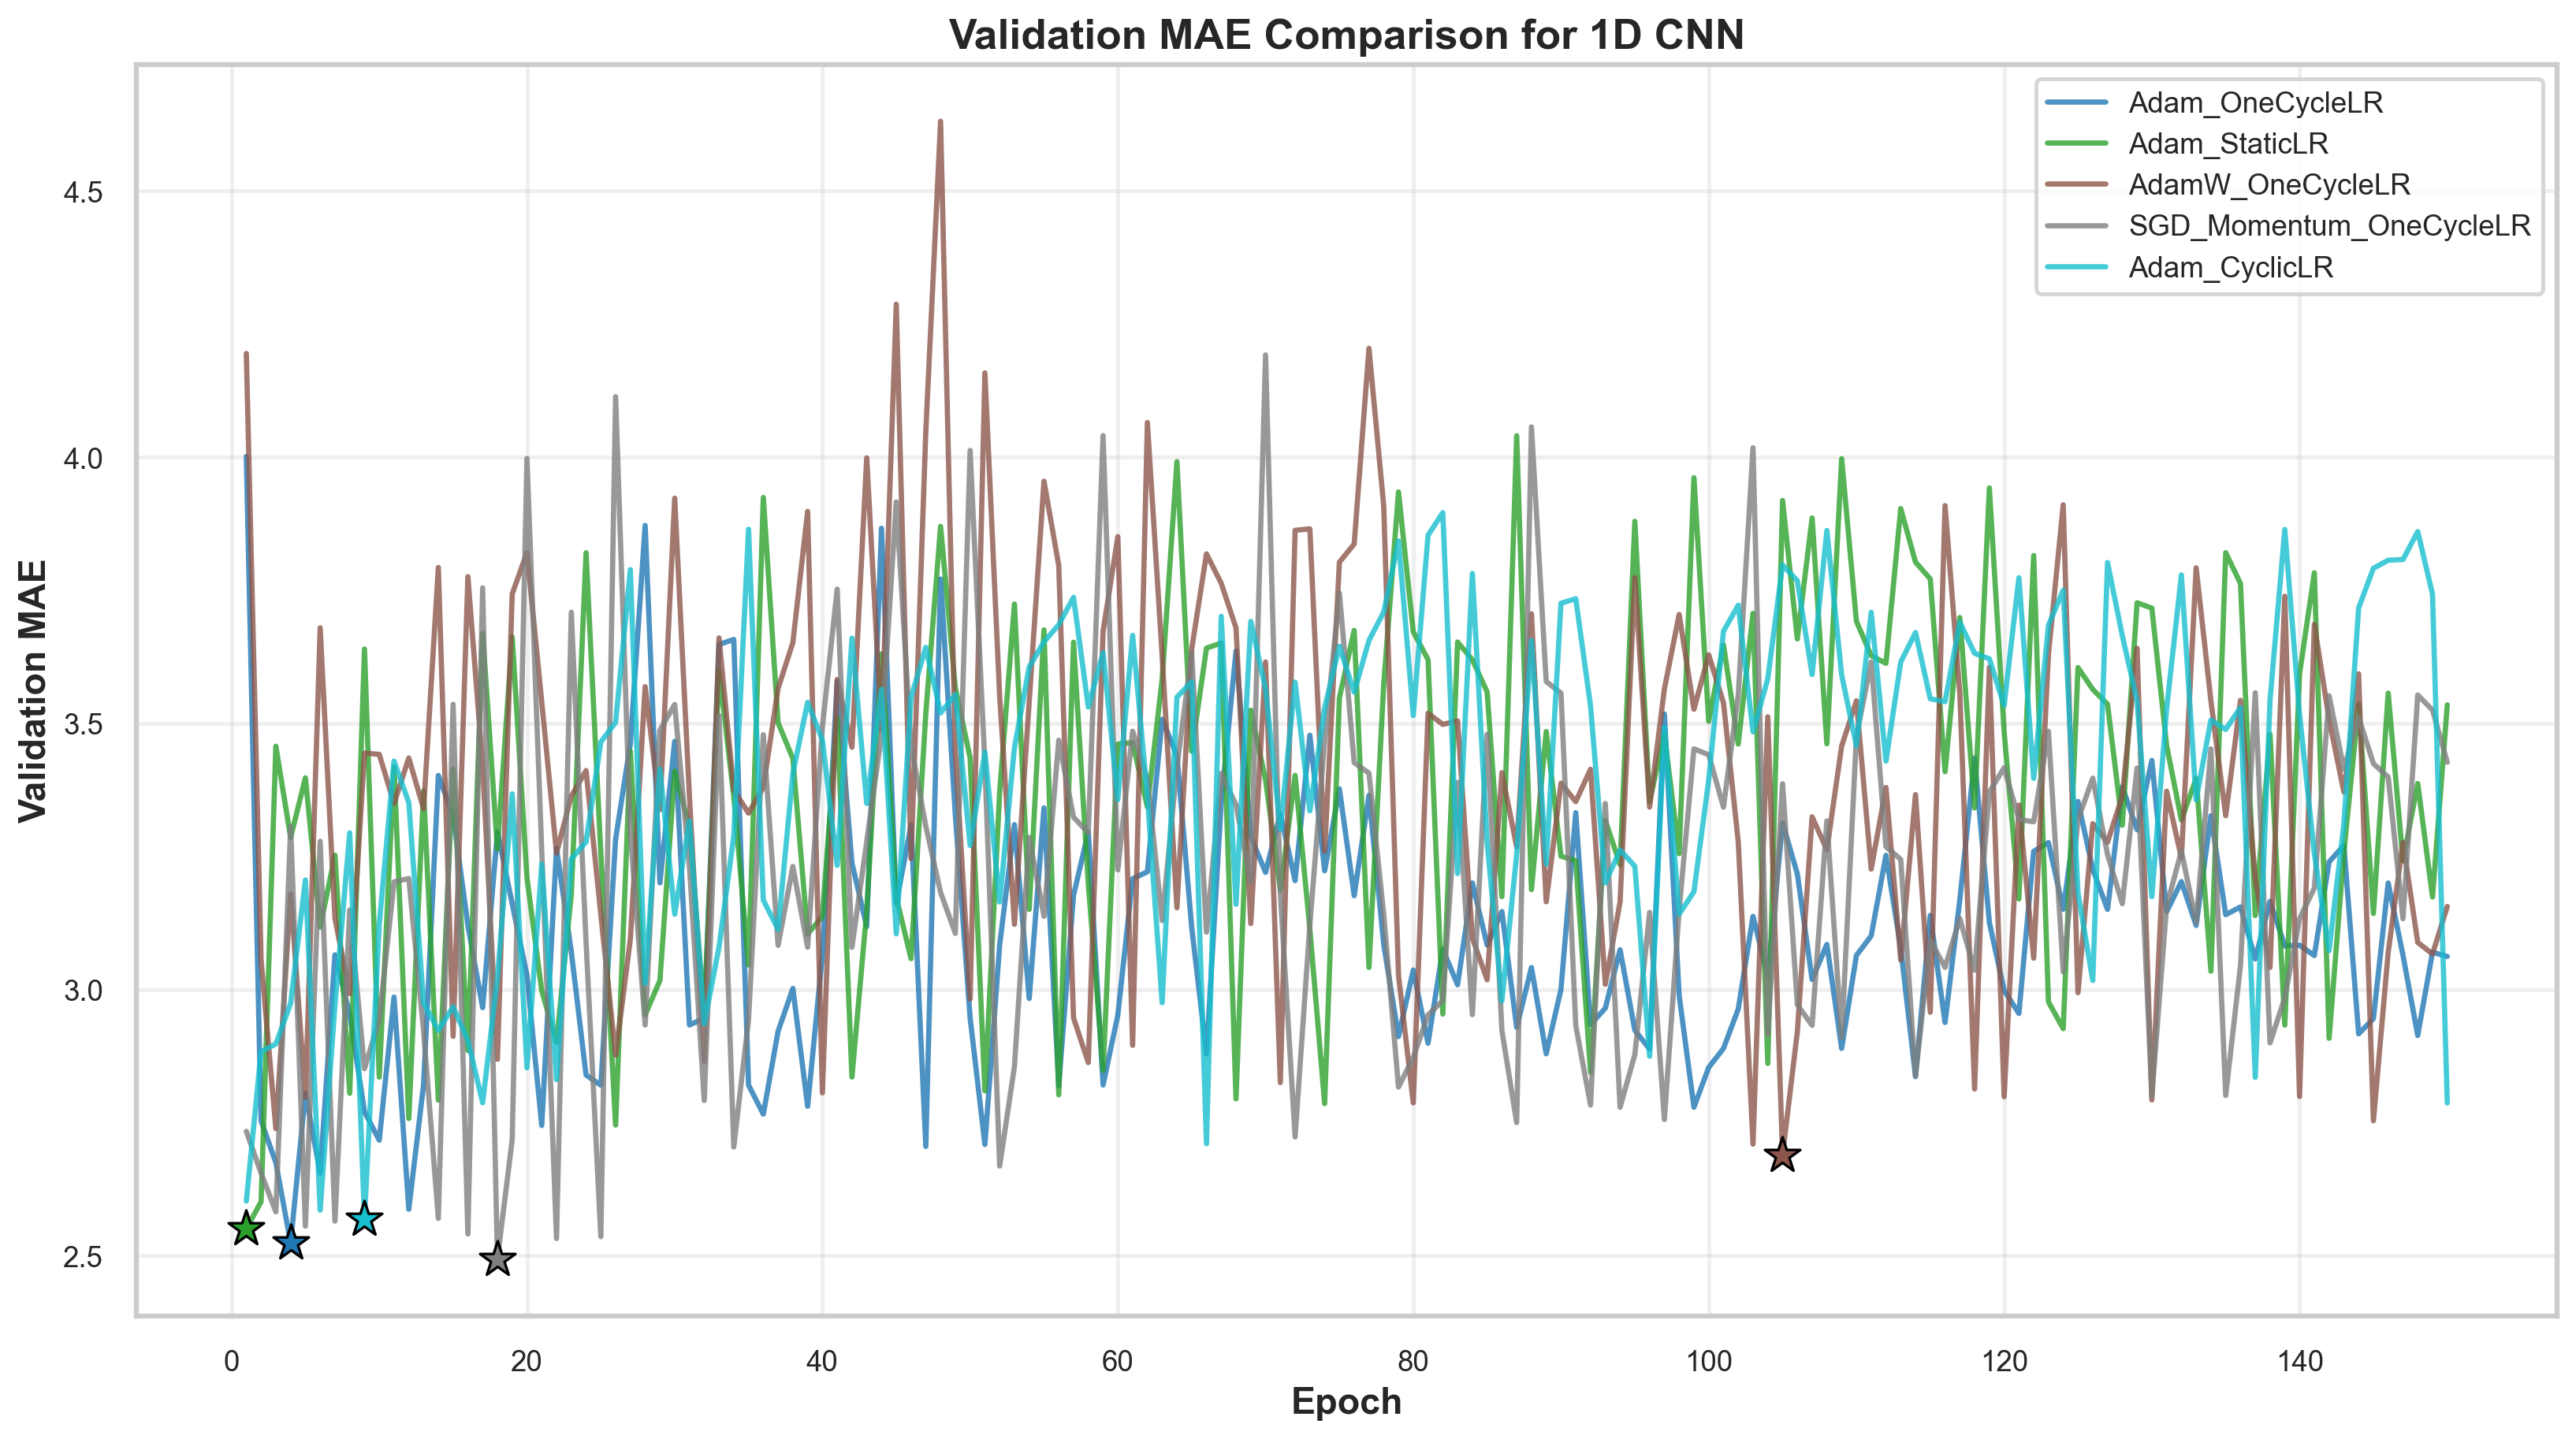


✓ Plot generated for 1D CNN


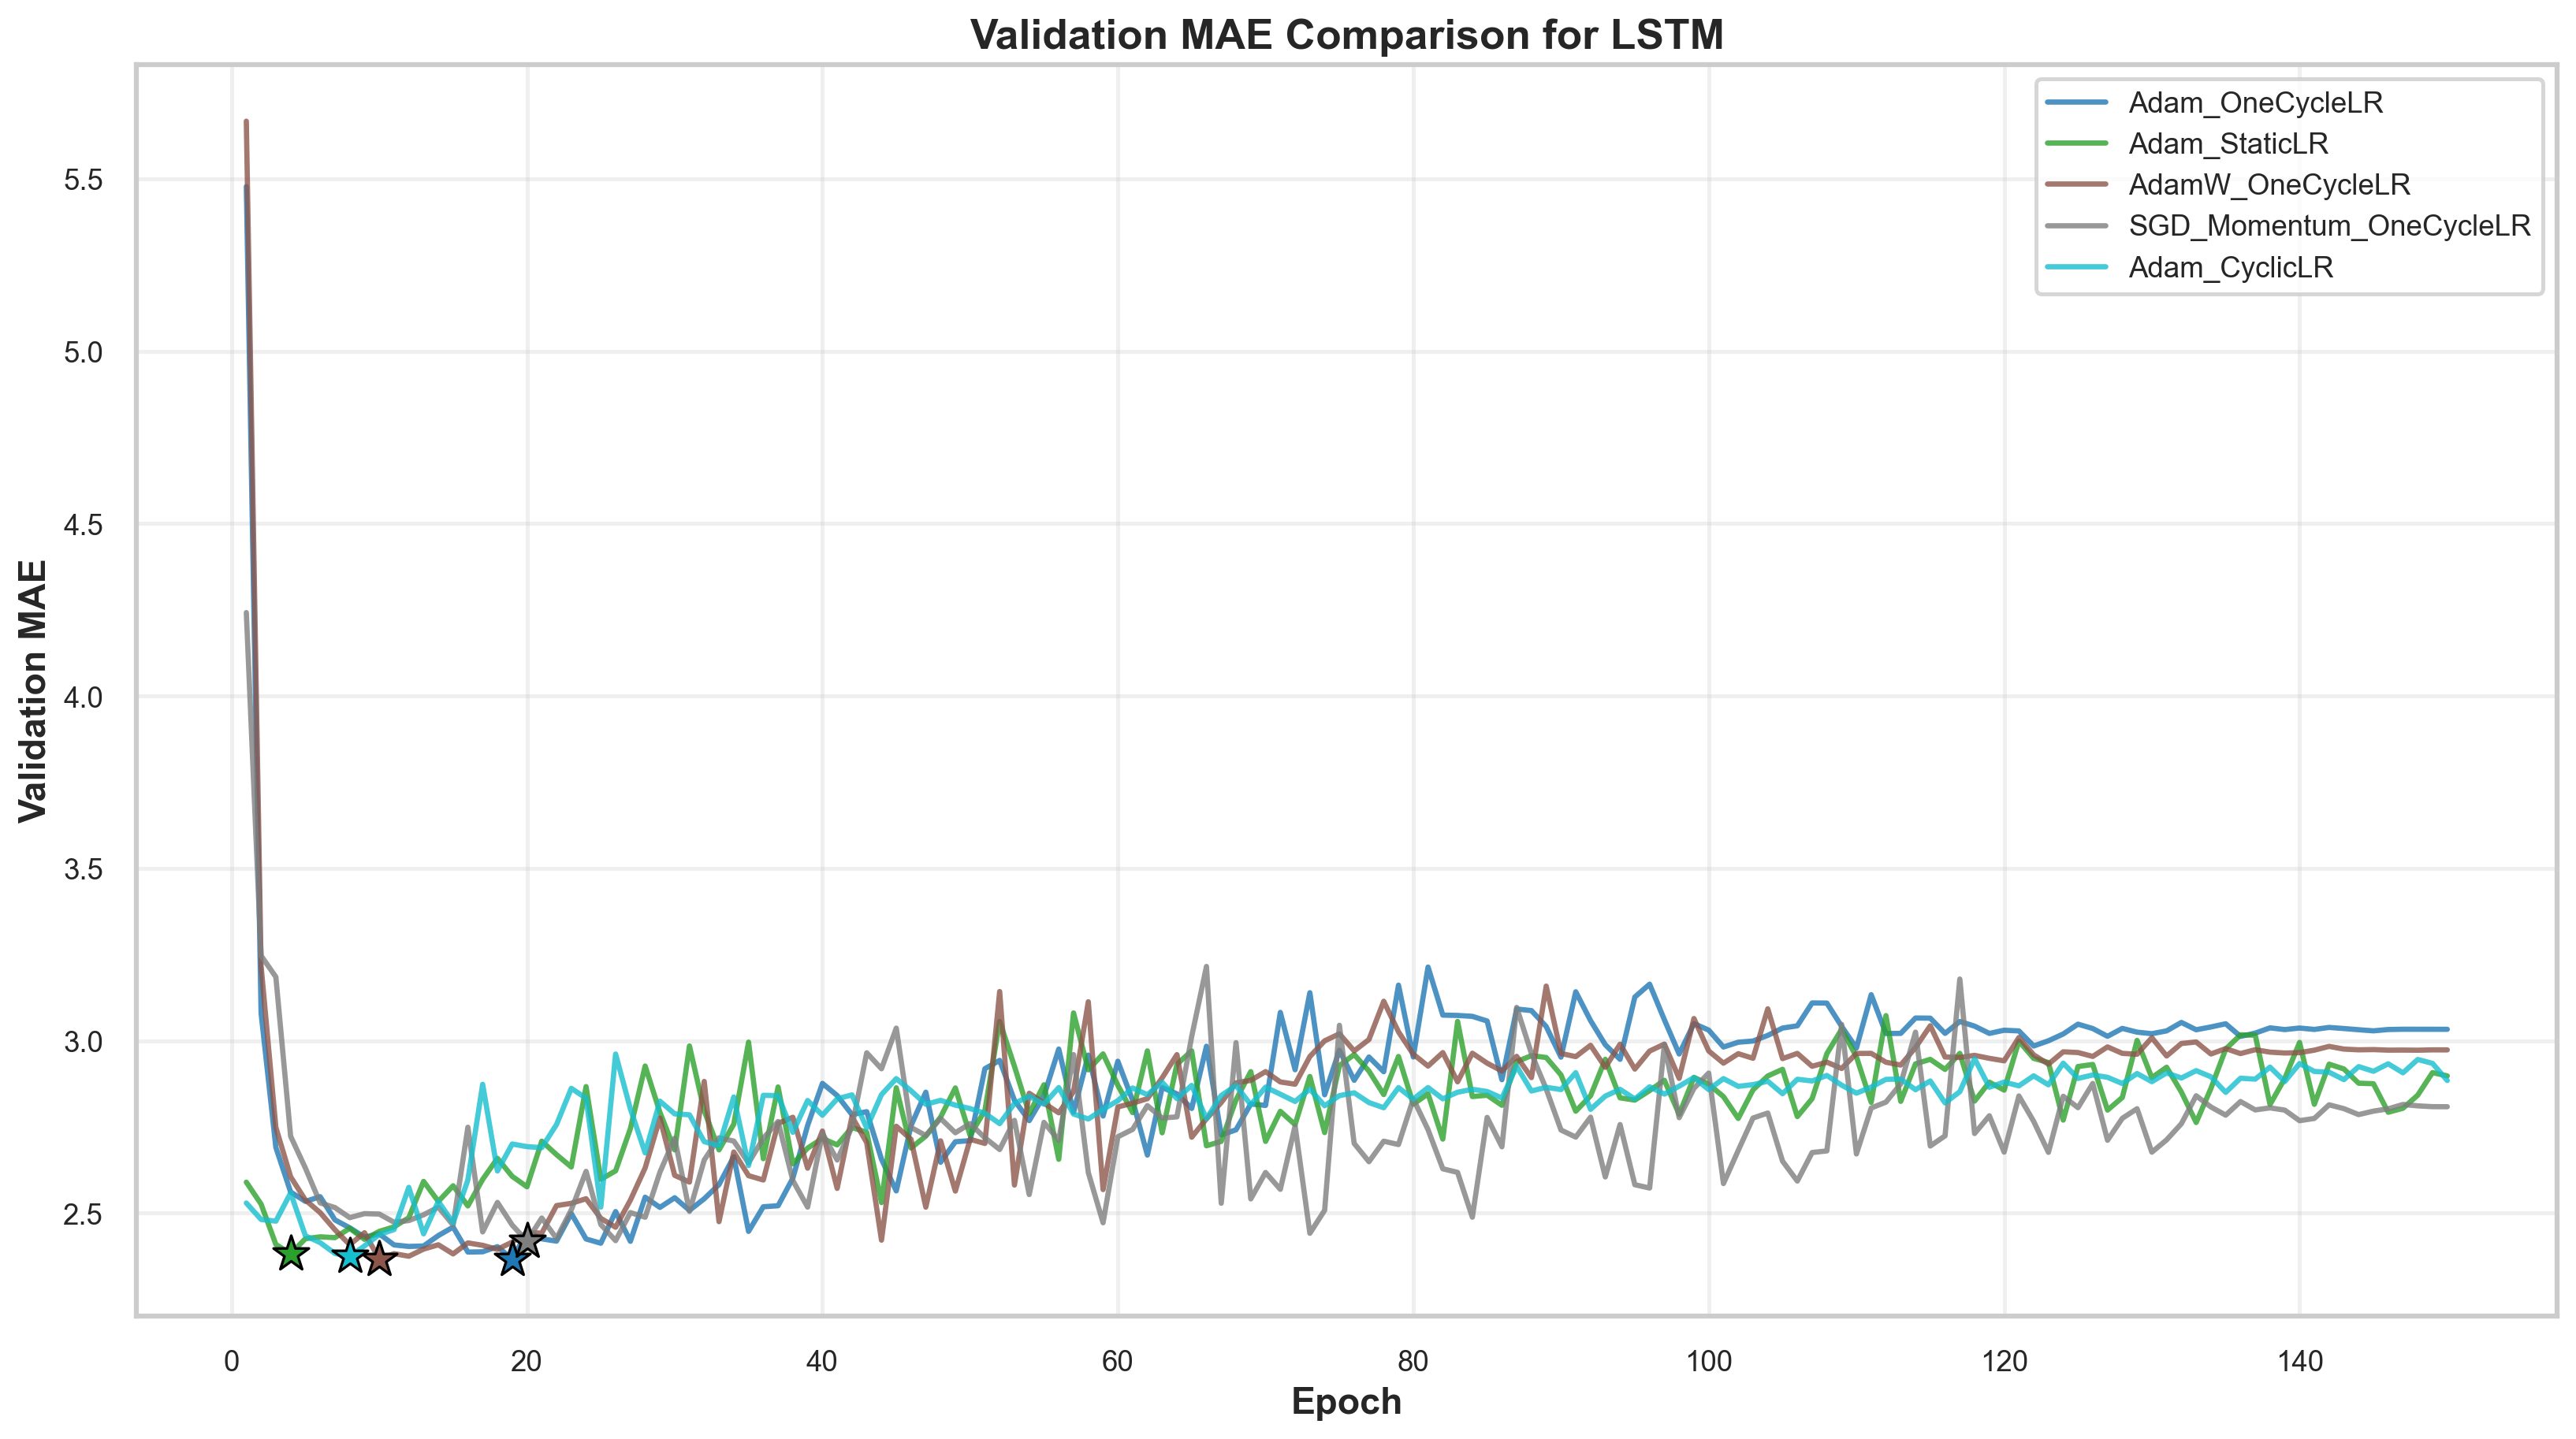


✓ Plot generated for LSTM


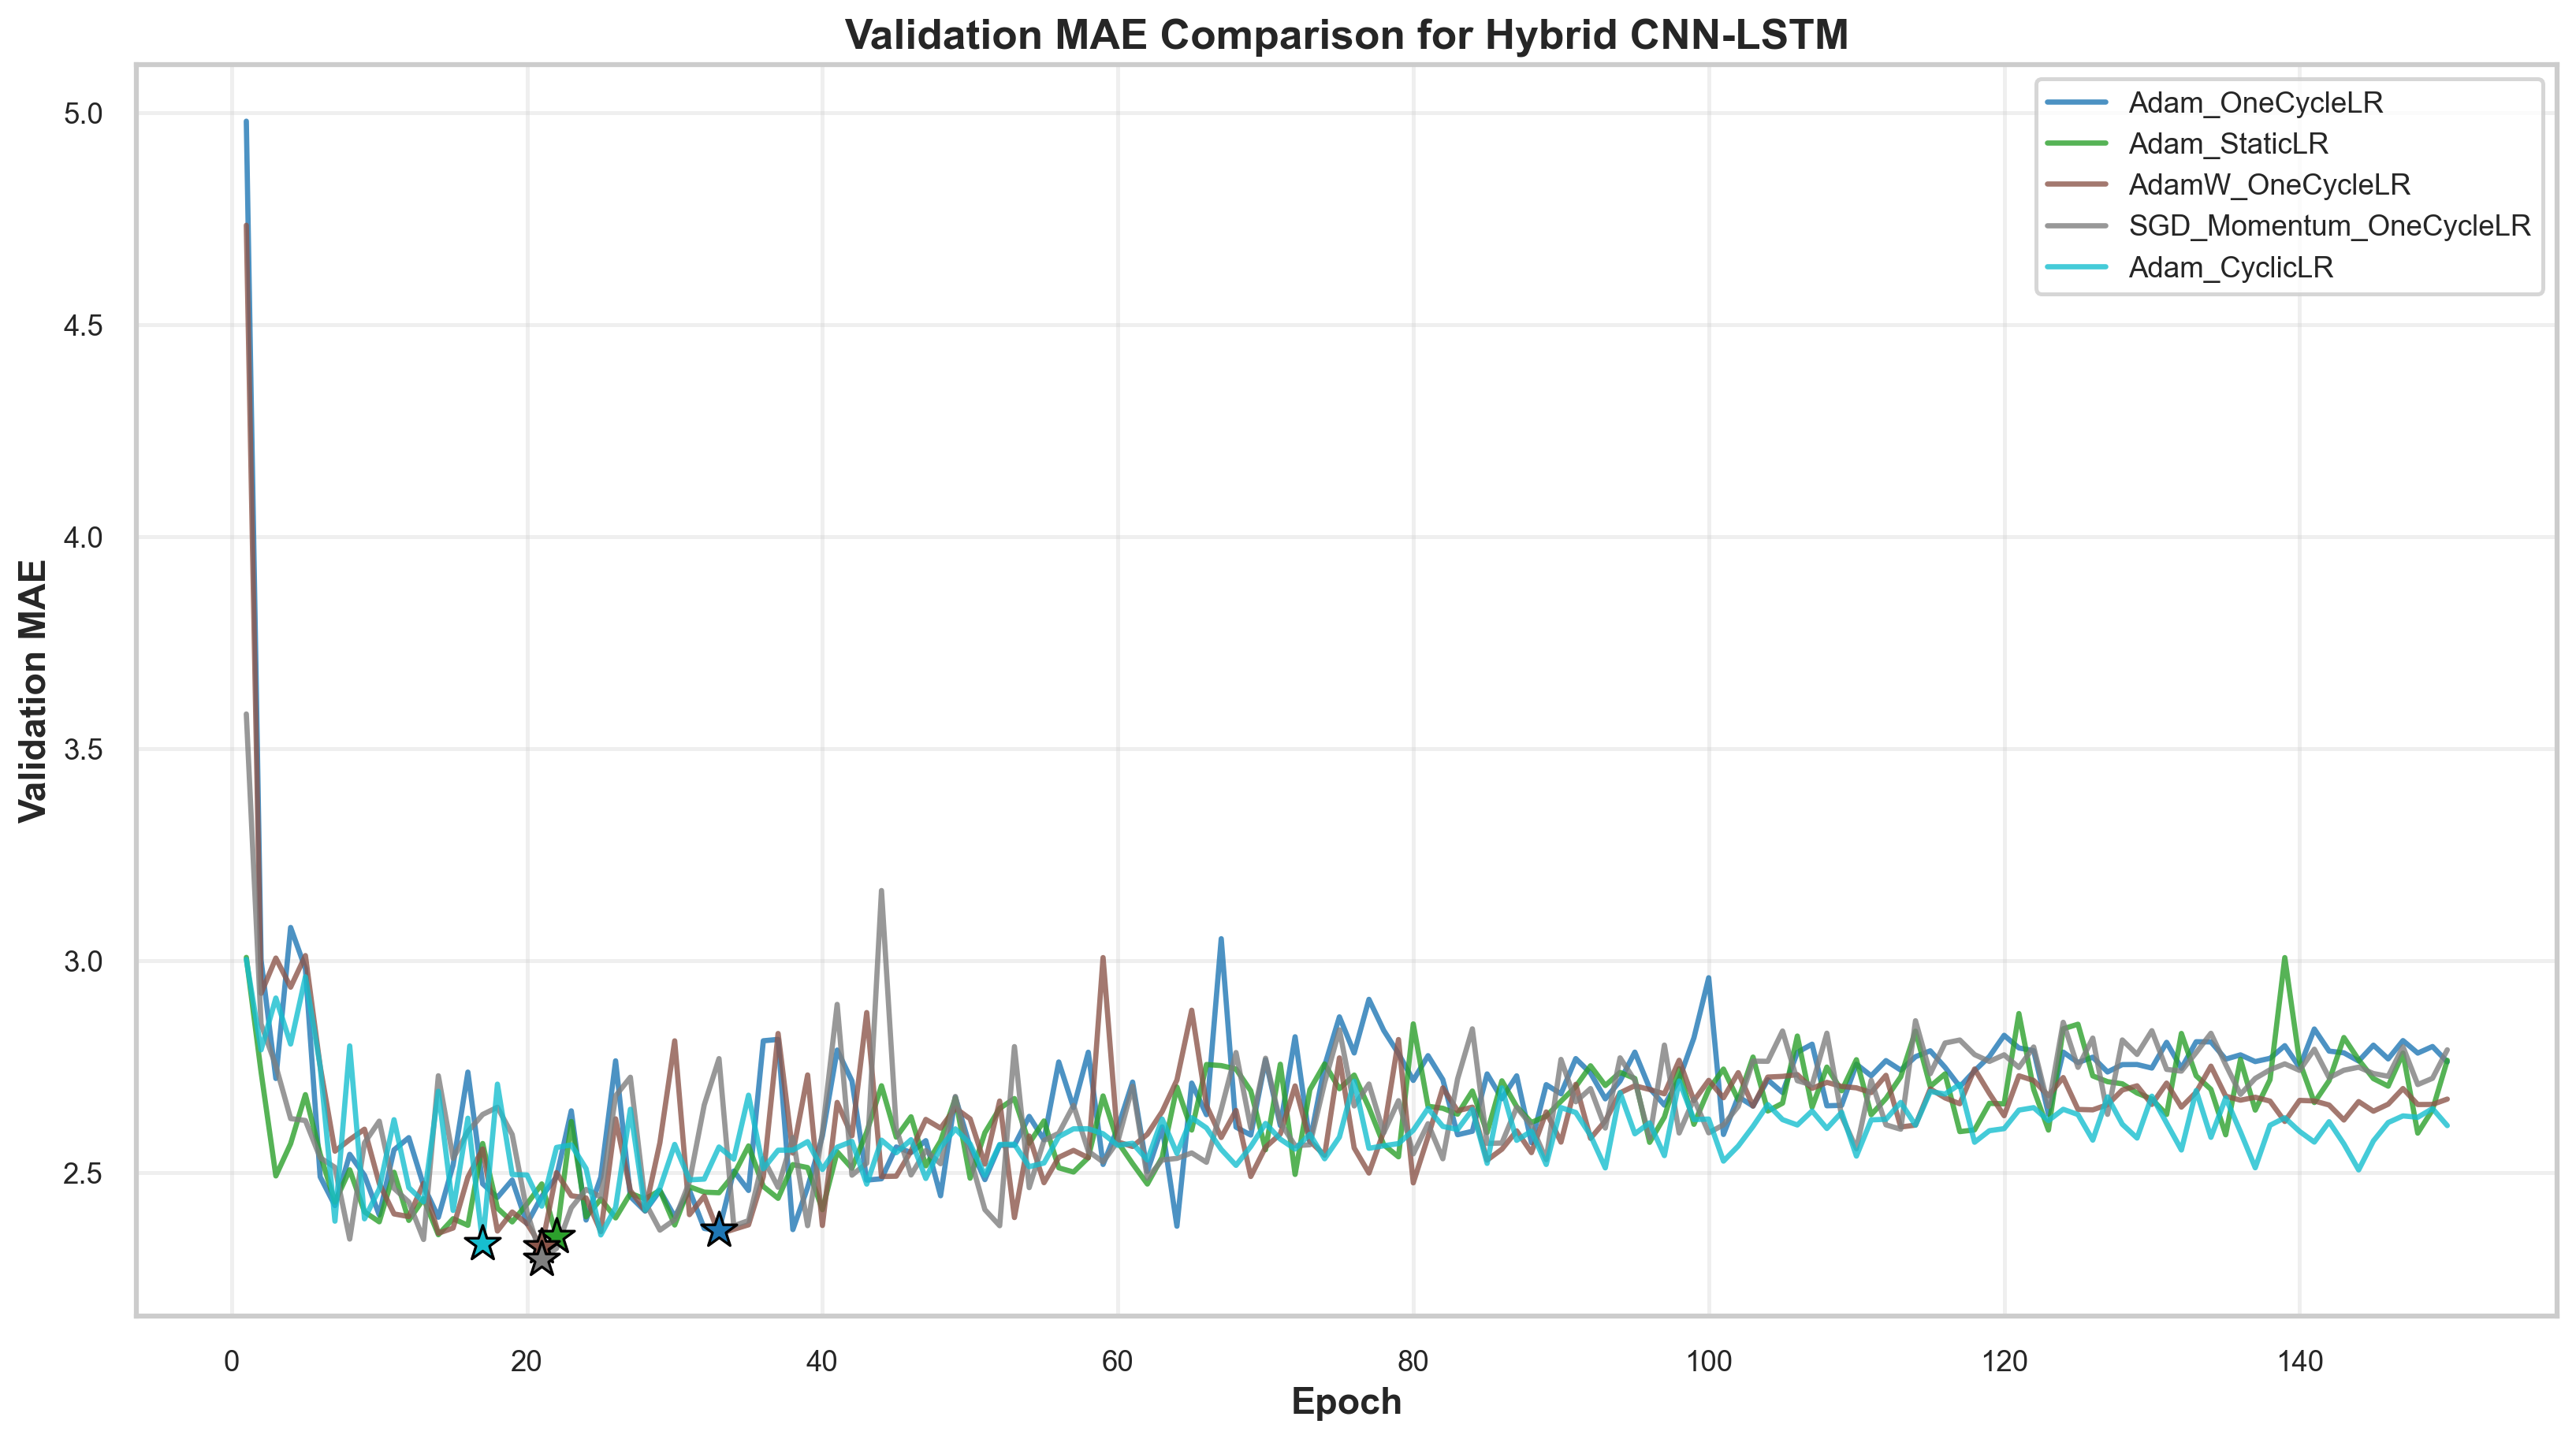


✓ Plot generated for Hybrid CNN-LSTM


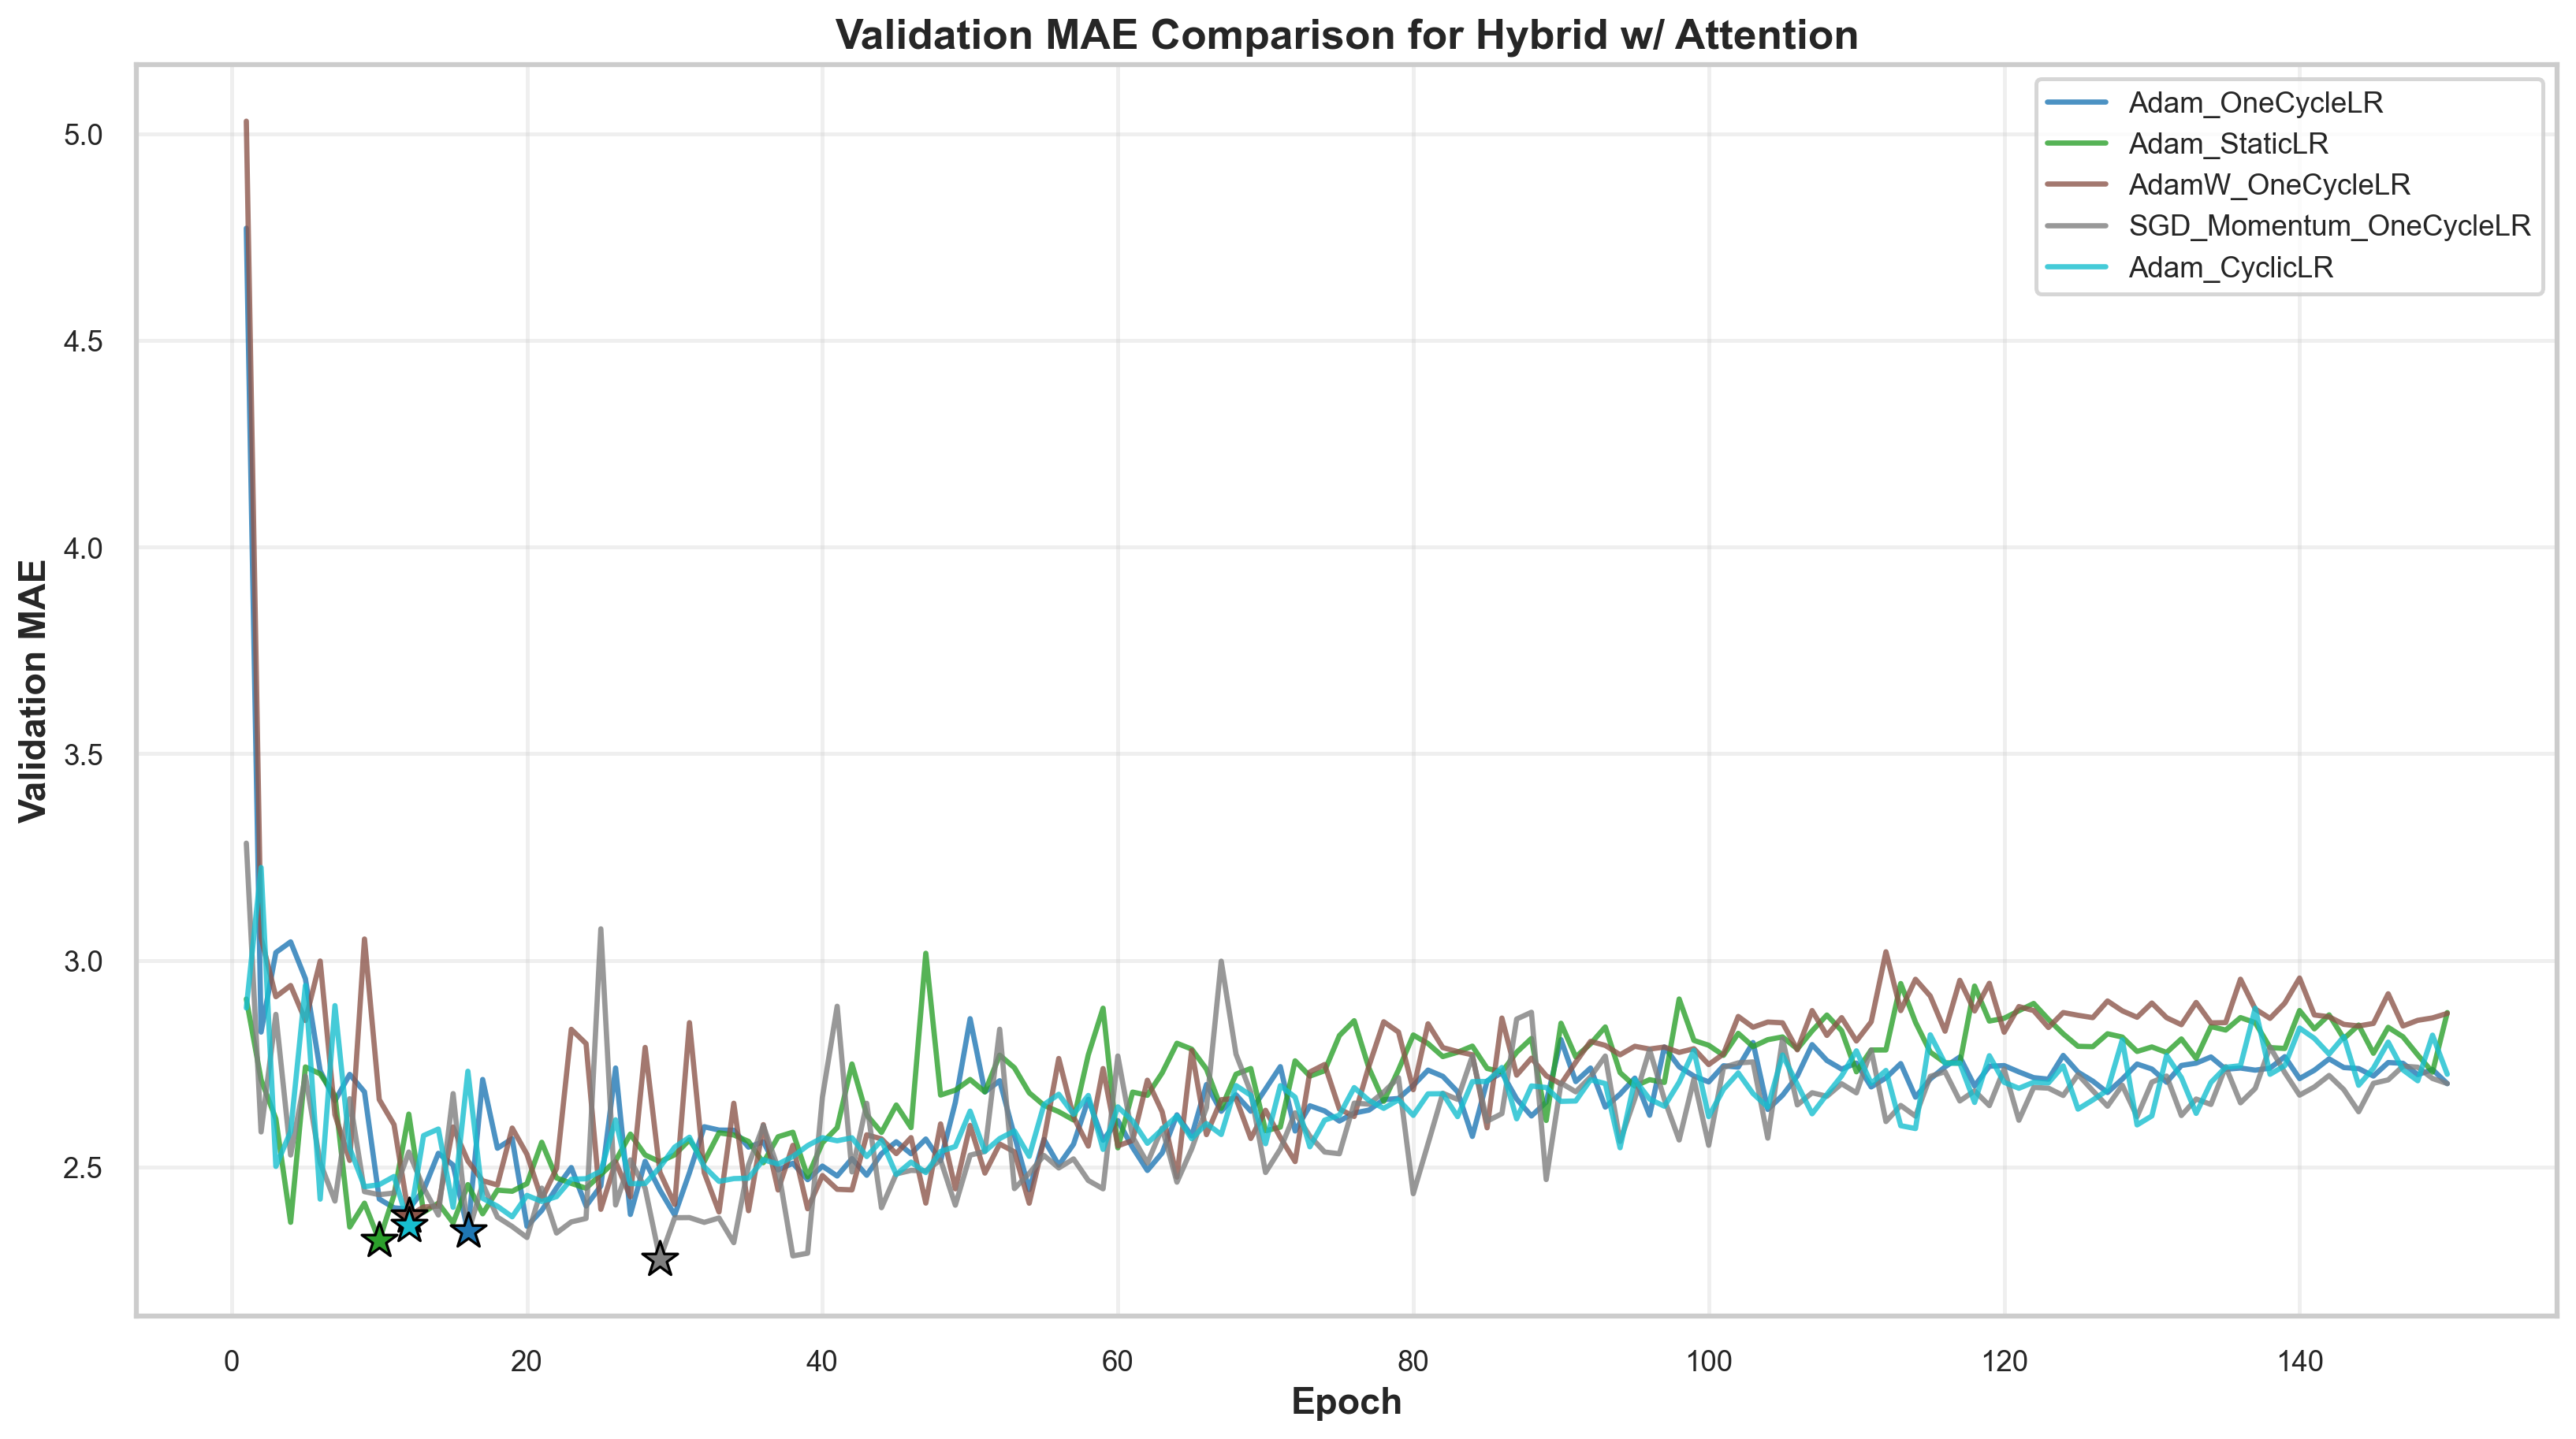


✓ Plot generated for Hybrid w/ Attention


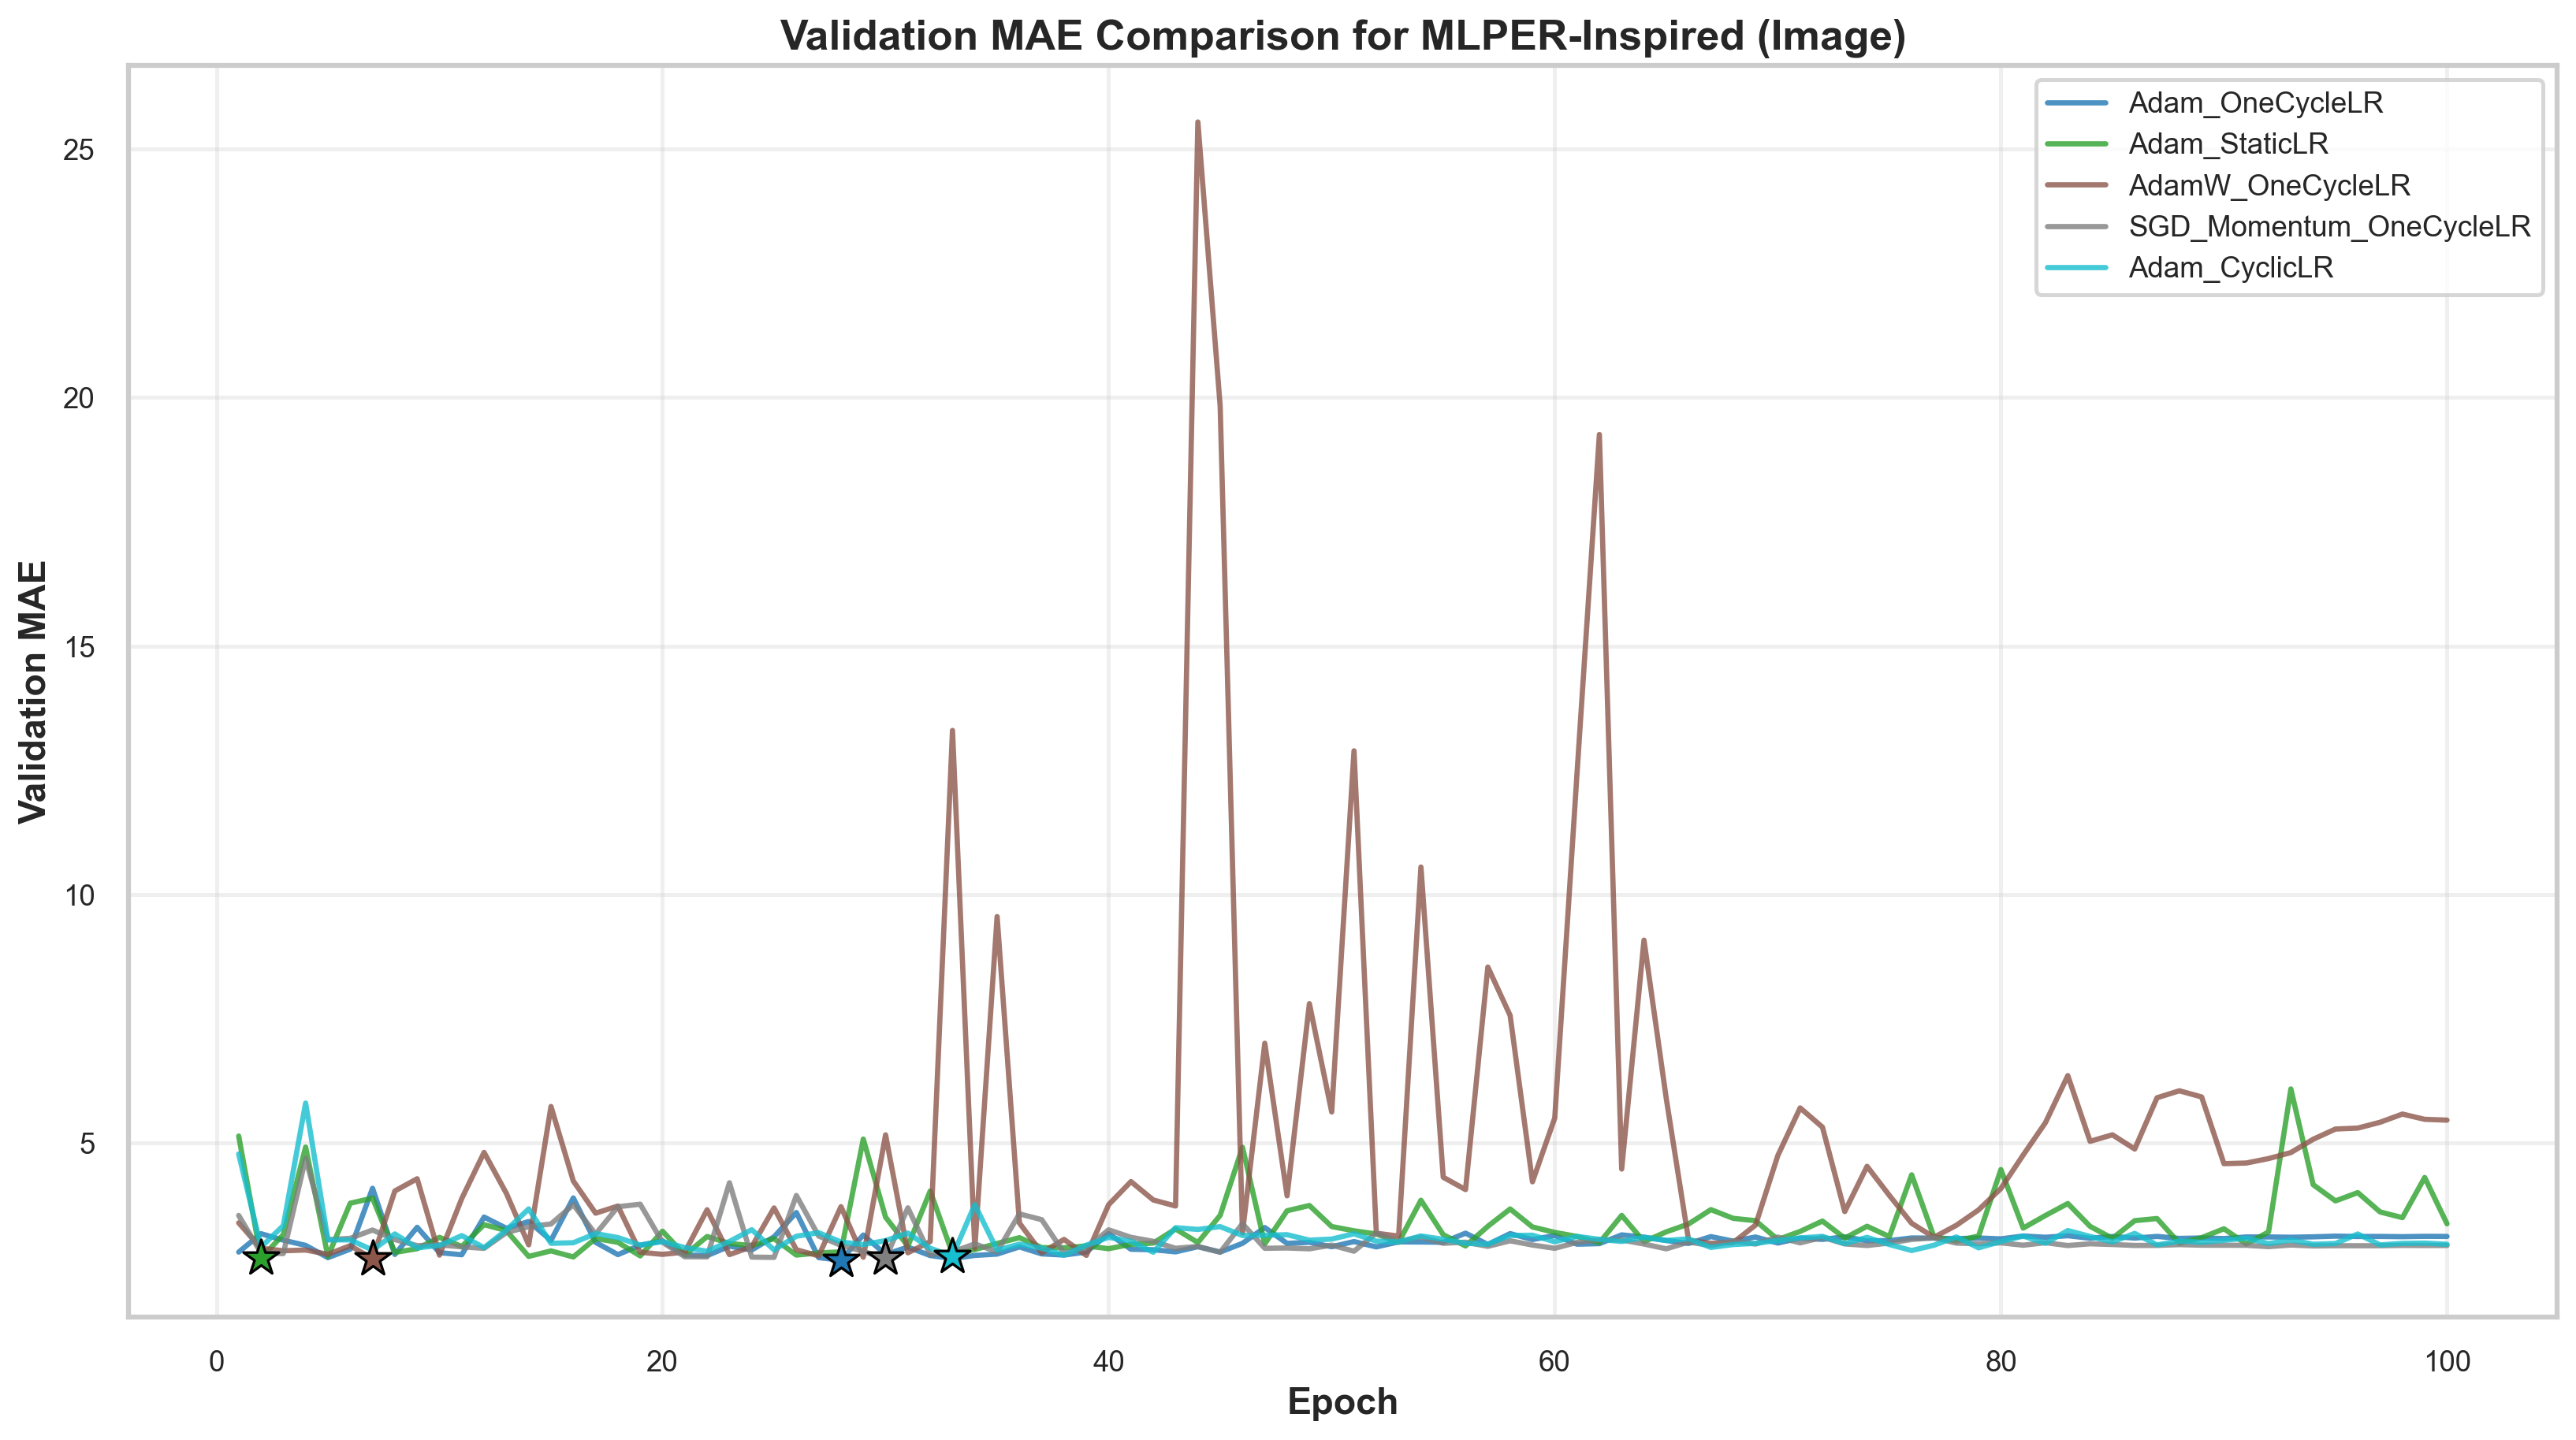


✓ Plot generated for MLPER-Inspired (Image)


In [18]:
# Load the modified training histories with optimizer comparisons
import json

try:
    with open('training_histories.json', 'r') as f:
        histories = json.load(f)
    
    # Get list of unique model names from the top-level keys
    model_names = list(histories.keys())
    print(f"Found {len(model_names)} models: {model_names}")
    
    # Create a separate plot for each model showing all optimizer validation losses
    for model_name in model_names:
        optimizer_results = histories[model_name]
        
        # Create figure for this model
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Plot validation loss for each optimizer
        colors = plt.cm.tab10(np.linspace(0, 1, len(optimizer_results)))
        for (optimizer_name, history), color in zip(optimizer_results.items(), colors):
            epochs = history['epoch']
            val_loss = history['val_loss']
            best_epoch = history['best_epoch']
            best_val_mae = history['best_val_mae']
            ax.plot(epochs, val_loss, label=optimizer_name, linewidth=2, alpha=0.8, color=color)
            # Add star marker at best epoch
            ax.scatter([best_epoch], [best_val_mae], color=color, s=200, zorder=5, marker='*', edgecolors='black', linewidths=1)
        
        # Set plot properties
        ax.set_xlabel('Epoch', fontsize=14, fontweight='bold')
        ax.set_ylabel('Validation MAE', fontsize=14, fontweight='bold')
        ax.set_title(f'Validation MAE Comparison for {model_name}', fontsize=16, fontweight='bold')
        ax.legend(fontsize=11, loc='best')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"\n✓ Plot generated for {model_name}")
    
except FileNotFoundError:
    print("training_histories.json not found. Please run 'python experiment.py' first.")
except Exception as e:
    print(f"Error loading training histories: {e}")
    import traceback
    traceback.print_exc()


## 6. Error Analysis of the Best Performer

This section dynamically identifies the best-performing model-optimizer combination from the experiment results, re-trains it for reproducibility, and generates error analysis plots to understand its performance characteristics.


--- Analyzing Best Performer: Hybrid w/ Attention with SGD_Momentum_OneCycleLR for 29 epochs ---

Re-training the best model...
Using device: cuda (NVIDIA GeForce RTX 4070 Laptop GPU)
CUDA Version: 12.4
Epoch 1/29 training complete.
Epoch 2/29 training complete.
Epoch 3/29 training complete.
Epoch 4/29 training complete.
Epoch 5/29 training complete.
Epoch 6/29 training complete.
Epoch 7/29 training complete.
Epoch 8/29 training complete.
Epoch 9/29 training complete.
Epoch 10/29 training complete.
Epoch 11/29 training complete.
Epoch 12/29 training complete.
Epoch 13/29 training complete.
Epoch 14/29 training complete.
Epoch 15/29 training complete.
Epoch 16/29 training complete.
Epoch 17/29 training complete.
Epoch 18/29 training complete.
Epoch 19/29 training complete.
Epoch 20/29 training complete.
Epoch 21/29 training complete.
Epoch 22/29 training complete.
Epoch 23/29 training complete.
Epoch 24/29 training complete.
Epoch 25/29 training complete.
Epoch 26/29 training complete.


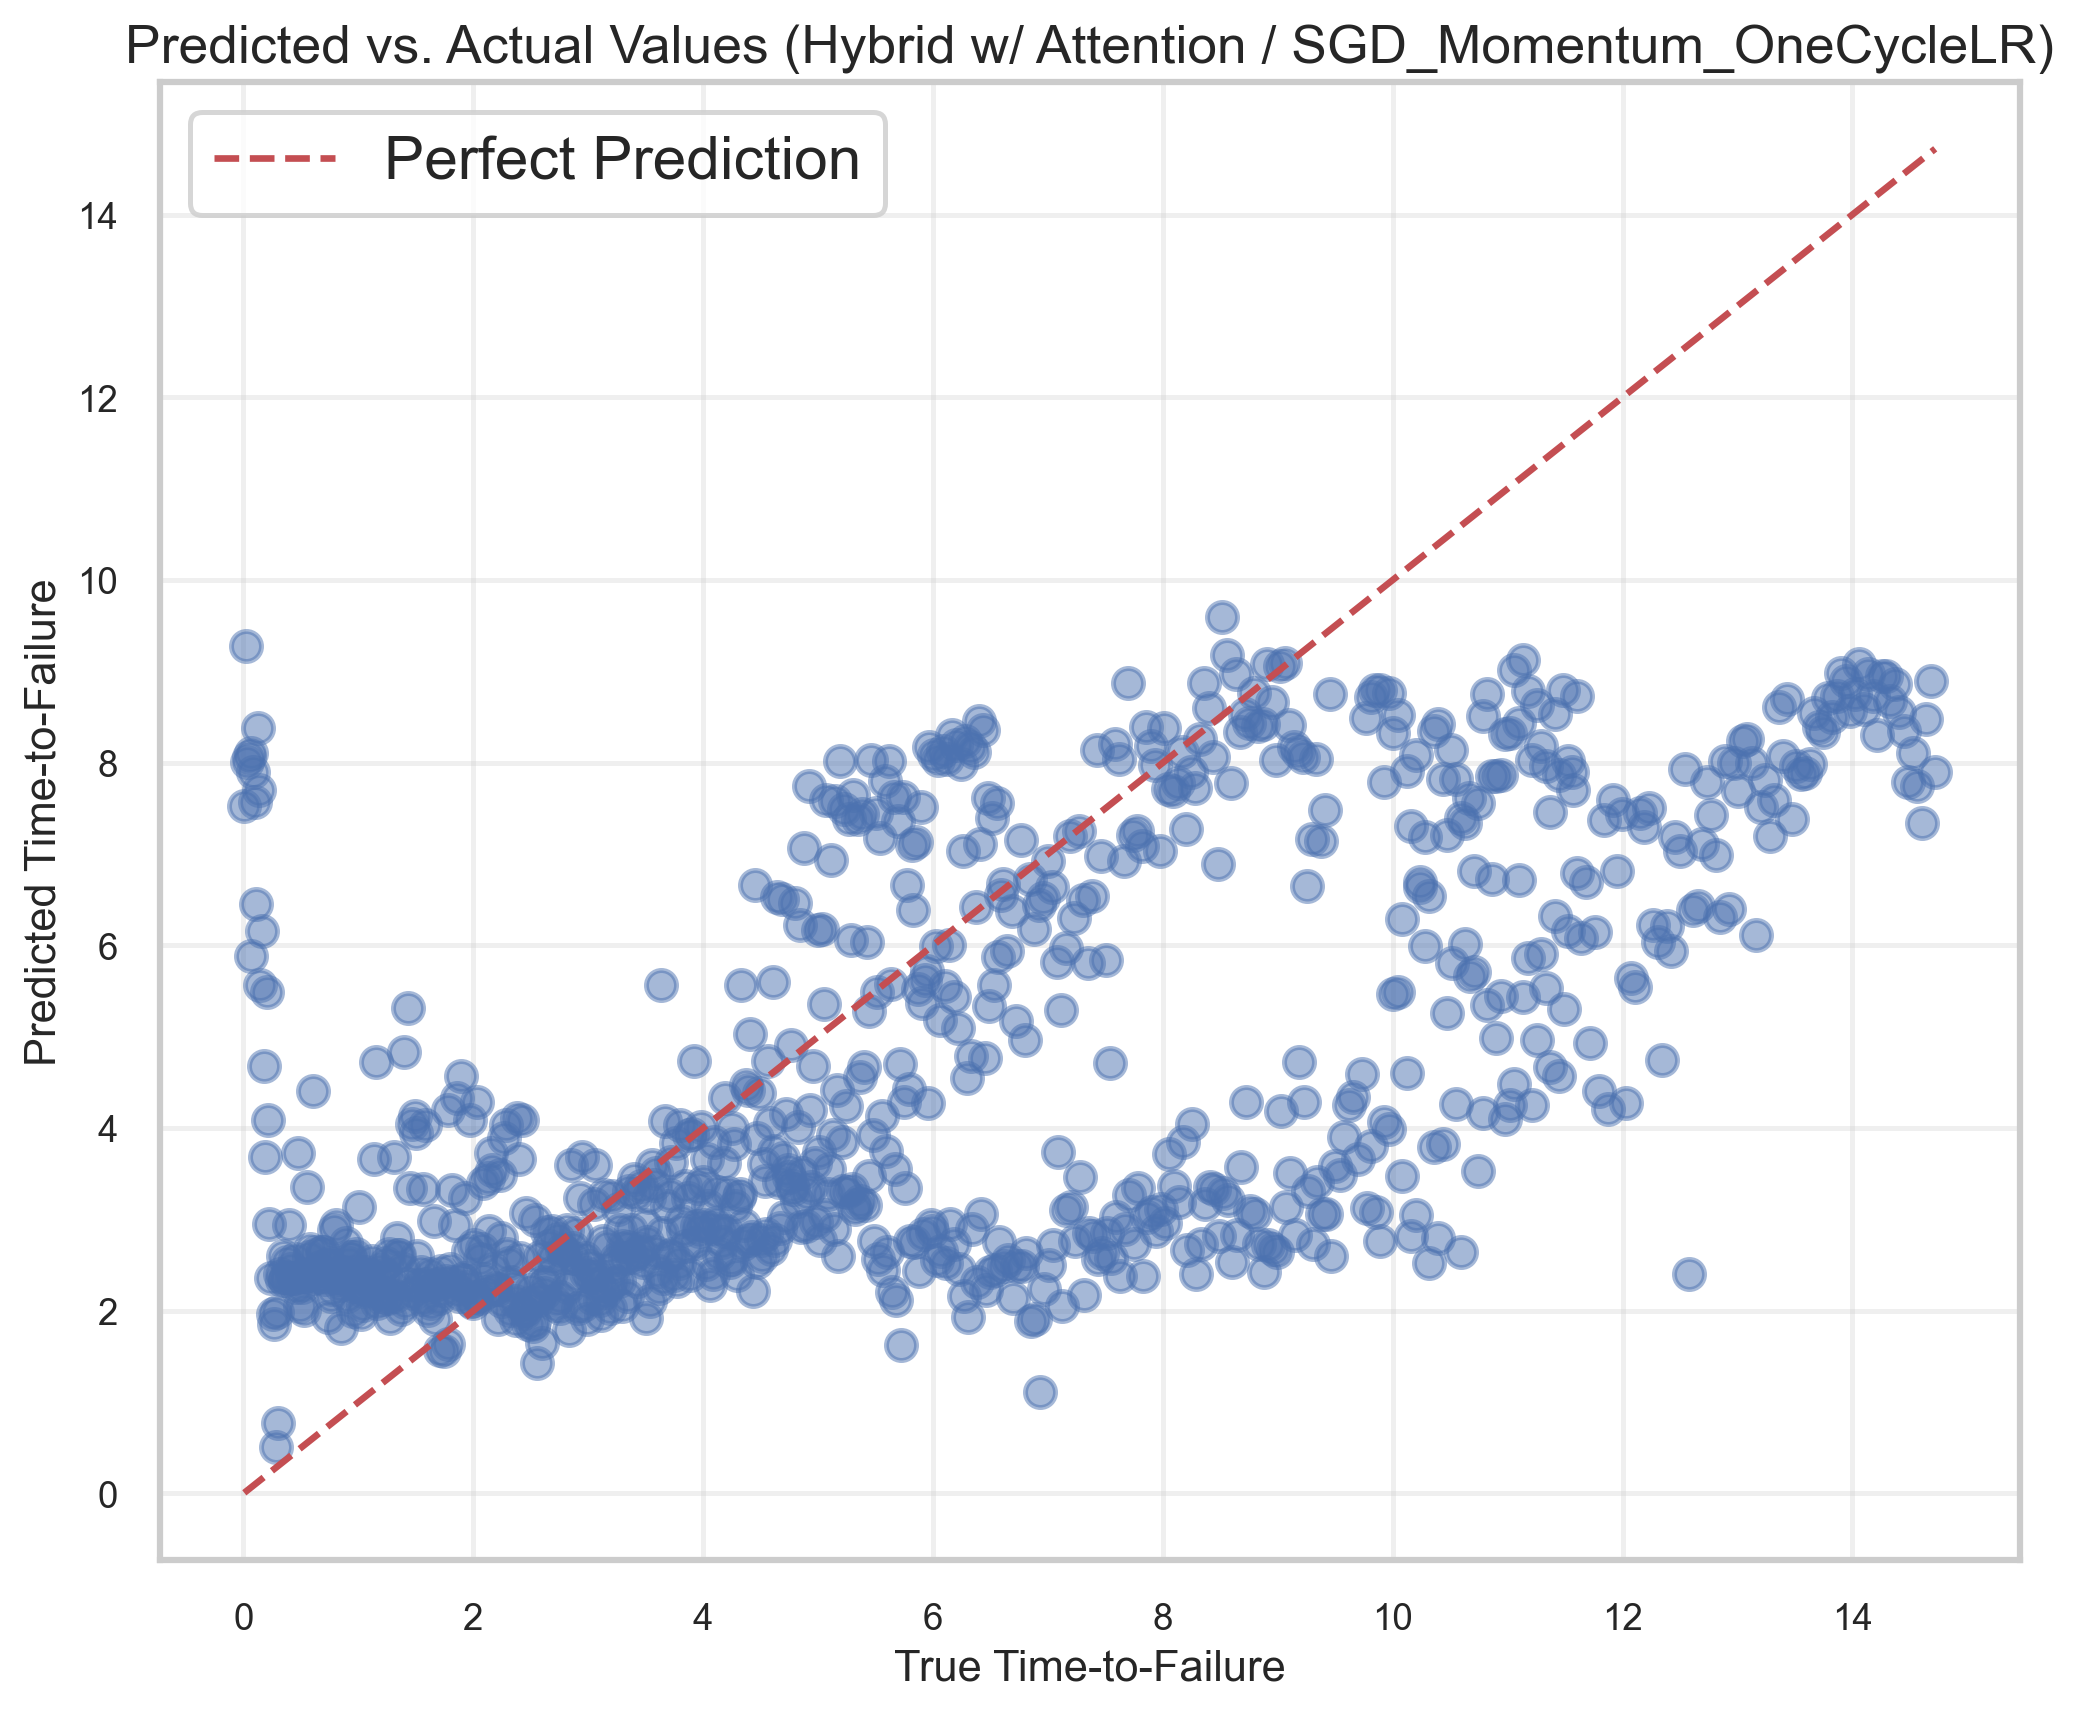

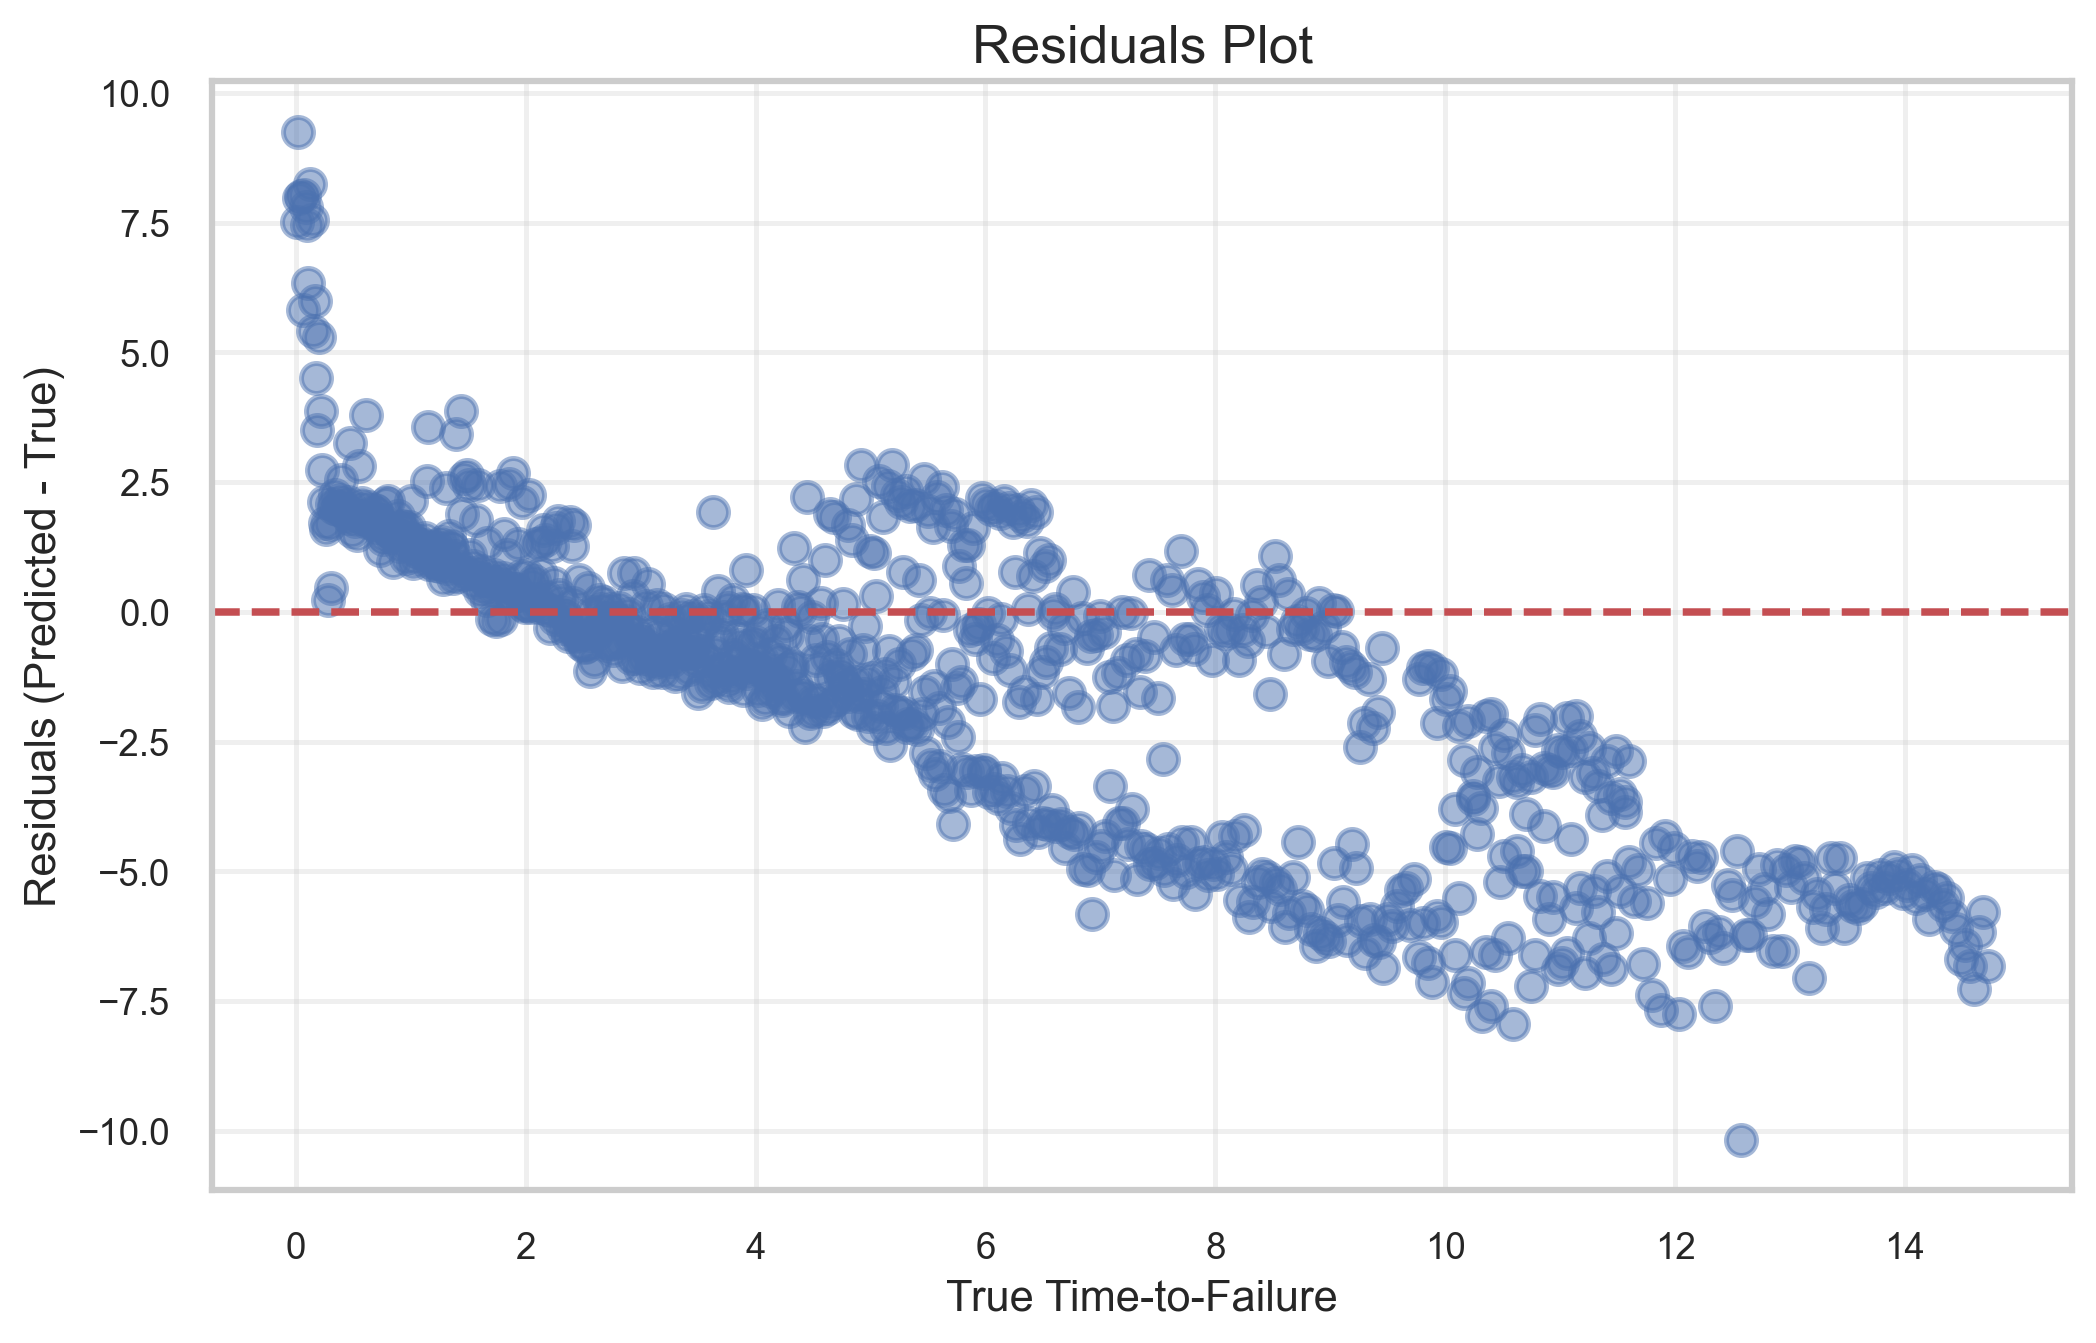

In [19]:
# This cell dynamically identifies the best performer, re-trains it, and generates error plots.
import config
from config import OPTIMIZER_CONFIGS
import image_models
from torch.nn import L1Loss

try:
    if 'performers_df' in locals() and not performers_df.empty:
        best_performer = performers_df.iloc[0]
        best_model_name = best_performer['Model']
        best_optimizer_name = best_performer['Optimizer']
        best_epochs = int(best_performer['Best_Epoch'])
        print(f"--- Analyzing Best Performer: {best_model_name} with {best_optimizer_name} for {best_epochs} epochs ---")
        
        is_image = "Image" in best_model_name
        
        # --- Model, Data, and Optimizer Setup ---
        model_map = {
            "1D CNN": models.CNNModel, "LSTM": models.LSTMModel,
            "Hybrid CNN-LSTM": models.HybridModel, "Hybrid w/ Attention": models.HybridAttention,
            "MLPER-Inspired (Image)": image_models.MLPERRegressionModel
        }
        ModelClass = model_map[best_model_name]
        if is_image:
            train_loader = torch.load('img_train_loader.pth', weights_only=False)
            val_loader = torch.load('img_val_loader.pth', weights_only=False)
            model = ModelClass()
        else:
            train_loader = torch.load('train_loader.pth', weights_only=False)
            val_loader = torch.load('val_loader.pth', weights_only=False)
            num_features = next(iter(train_loader))[0].shape[-1]
            model = ModelClass(input_features=num_features)
        
        opt_config = next((item for item in OPTIMIZER_CONFIGS if item['name'] == best_optimizer_name), None)
        if opt_config is None:
            raise ValueError(f"Optimizer config '{best_optimizer_name}' not found in OPTIMIZER_CONFIGS")
        
        optimizer_class = {'Adam': torch.optim.Adam, 'AdamW': torch.optim.AdamW, 'SGD': torch.optim.SGD}[opt_config['optimizer']]
        optimizer_kwargs = {'lr': opt_config['lr']}
        if 'weight_decay' in opt_config:
            optimizer_kwargs['weight_decay'] = opt_config['weight_decay']
        if 'momentum' in opt_config:
            optimizer_kwargs['momentum'] = opt_config['momentum']
        optimizer = optimizer_class(model.parameters(), **optimizer_kwargs)
        
        # --- Re-training Loop ---
        print("\nRe-training the best model...")
        device = utils.get_device()
        model.to(device)
        criterion = L1Loss()
        
        for epoch in range(best_epochs):
            model.train()
            for batch in train_loader:
                optimizer.zero_grad()
                if is_image:
                    mag, phase, labels = [d.to(device) for d in batch]
                    outputs = model(mag, phase)
                else:
                    inputs, labels = [d.to(device) for d in batch]
                    outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            print(f"Epoch {epoch+1}/{best_epochs} training complete.")
        
        # --- Prediction and Plotting ---
        print("\nGenerating predictions on validation set...")
        preds, trues = [], []
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                if is_image:
                    mag, phase, yb = batch
                    outputs = model(mag.to(device), phase.to(device))
                else:
                    Xb, yb = batch
                    outputs = model(Xb.to(device))
                preds.extend(outputs.cpu().numpy().flatten())
                trues.extend(yb.numpy().flatten())
        
        arr_true, arr_pred = np.array(trues), np.array(preds)
        residuals = arr_pred - arr_true
        
        plt.figure(figsize=(10, 8))
        plt.scatter(arr_true, arr_pred, alpha=0.5)
        plt.plot([min(arr_true), max(arr_true)], [min(arr_true), max(arr_true)], 'r--', lw=2, label='Perfect Prediction')
        plt.xlabel('True Time-to-Failure')
        plt.ylabel('Predicted Time-to-Failure')
        plt.title(f'Predicted vs. Actual Values ({best_model_name} / {best_optimizer_name})')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.scatter(arr_true, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('True Time-to-Failure')
        plt.ylabel('Residuals (Predicted - True)')
        plt.title('Residuals Plot')
        plt.grid(True)
        plt.show()
    else:
        print("Could not find performers_df. Please run the summary cell first.")
except Exception as e:
    print(f"An error occurred during error analysis: {e}")
    import traceback
    traceback.print_exc()


## 7. Optimizer Performance Comparison


Found 5 models: ['1D CNN', 'LSTM', 'Hybrid CNN-LSTM', 'Hybrid w/ Attention', 'MLPER-Inspired (Image)']


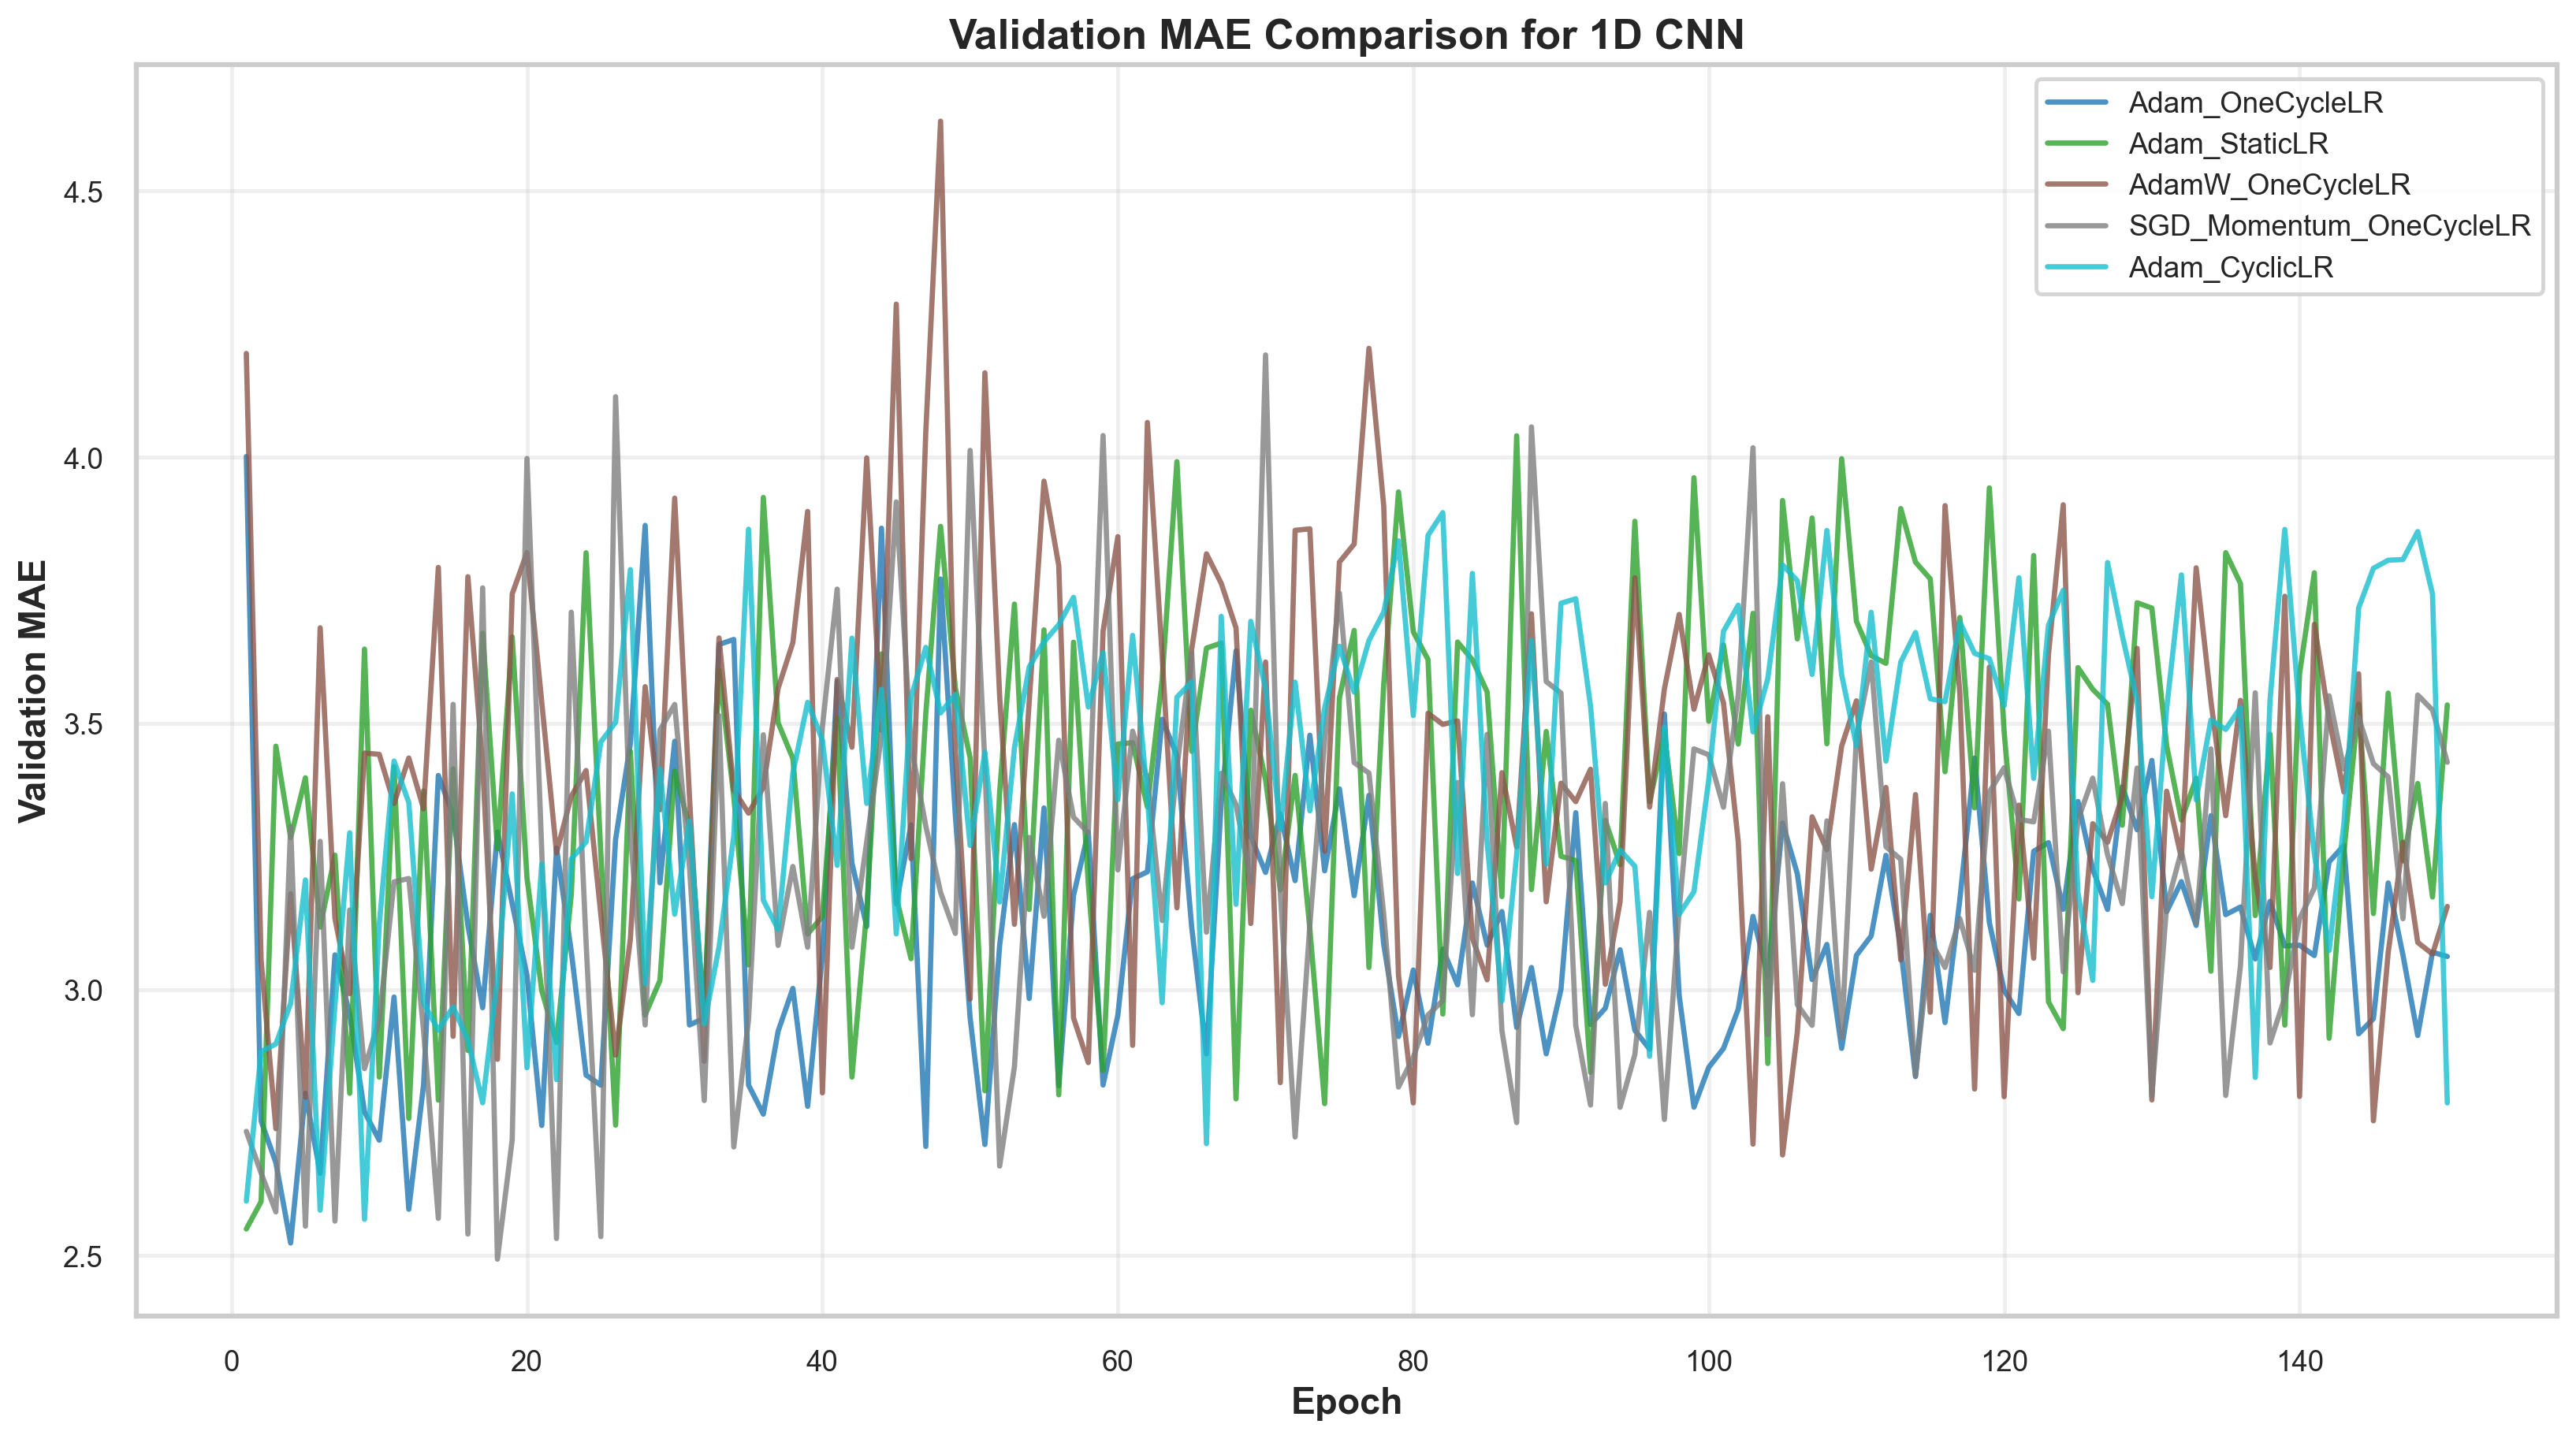


✓ Plot generated for 1D CNN


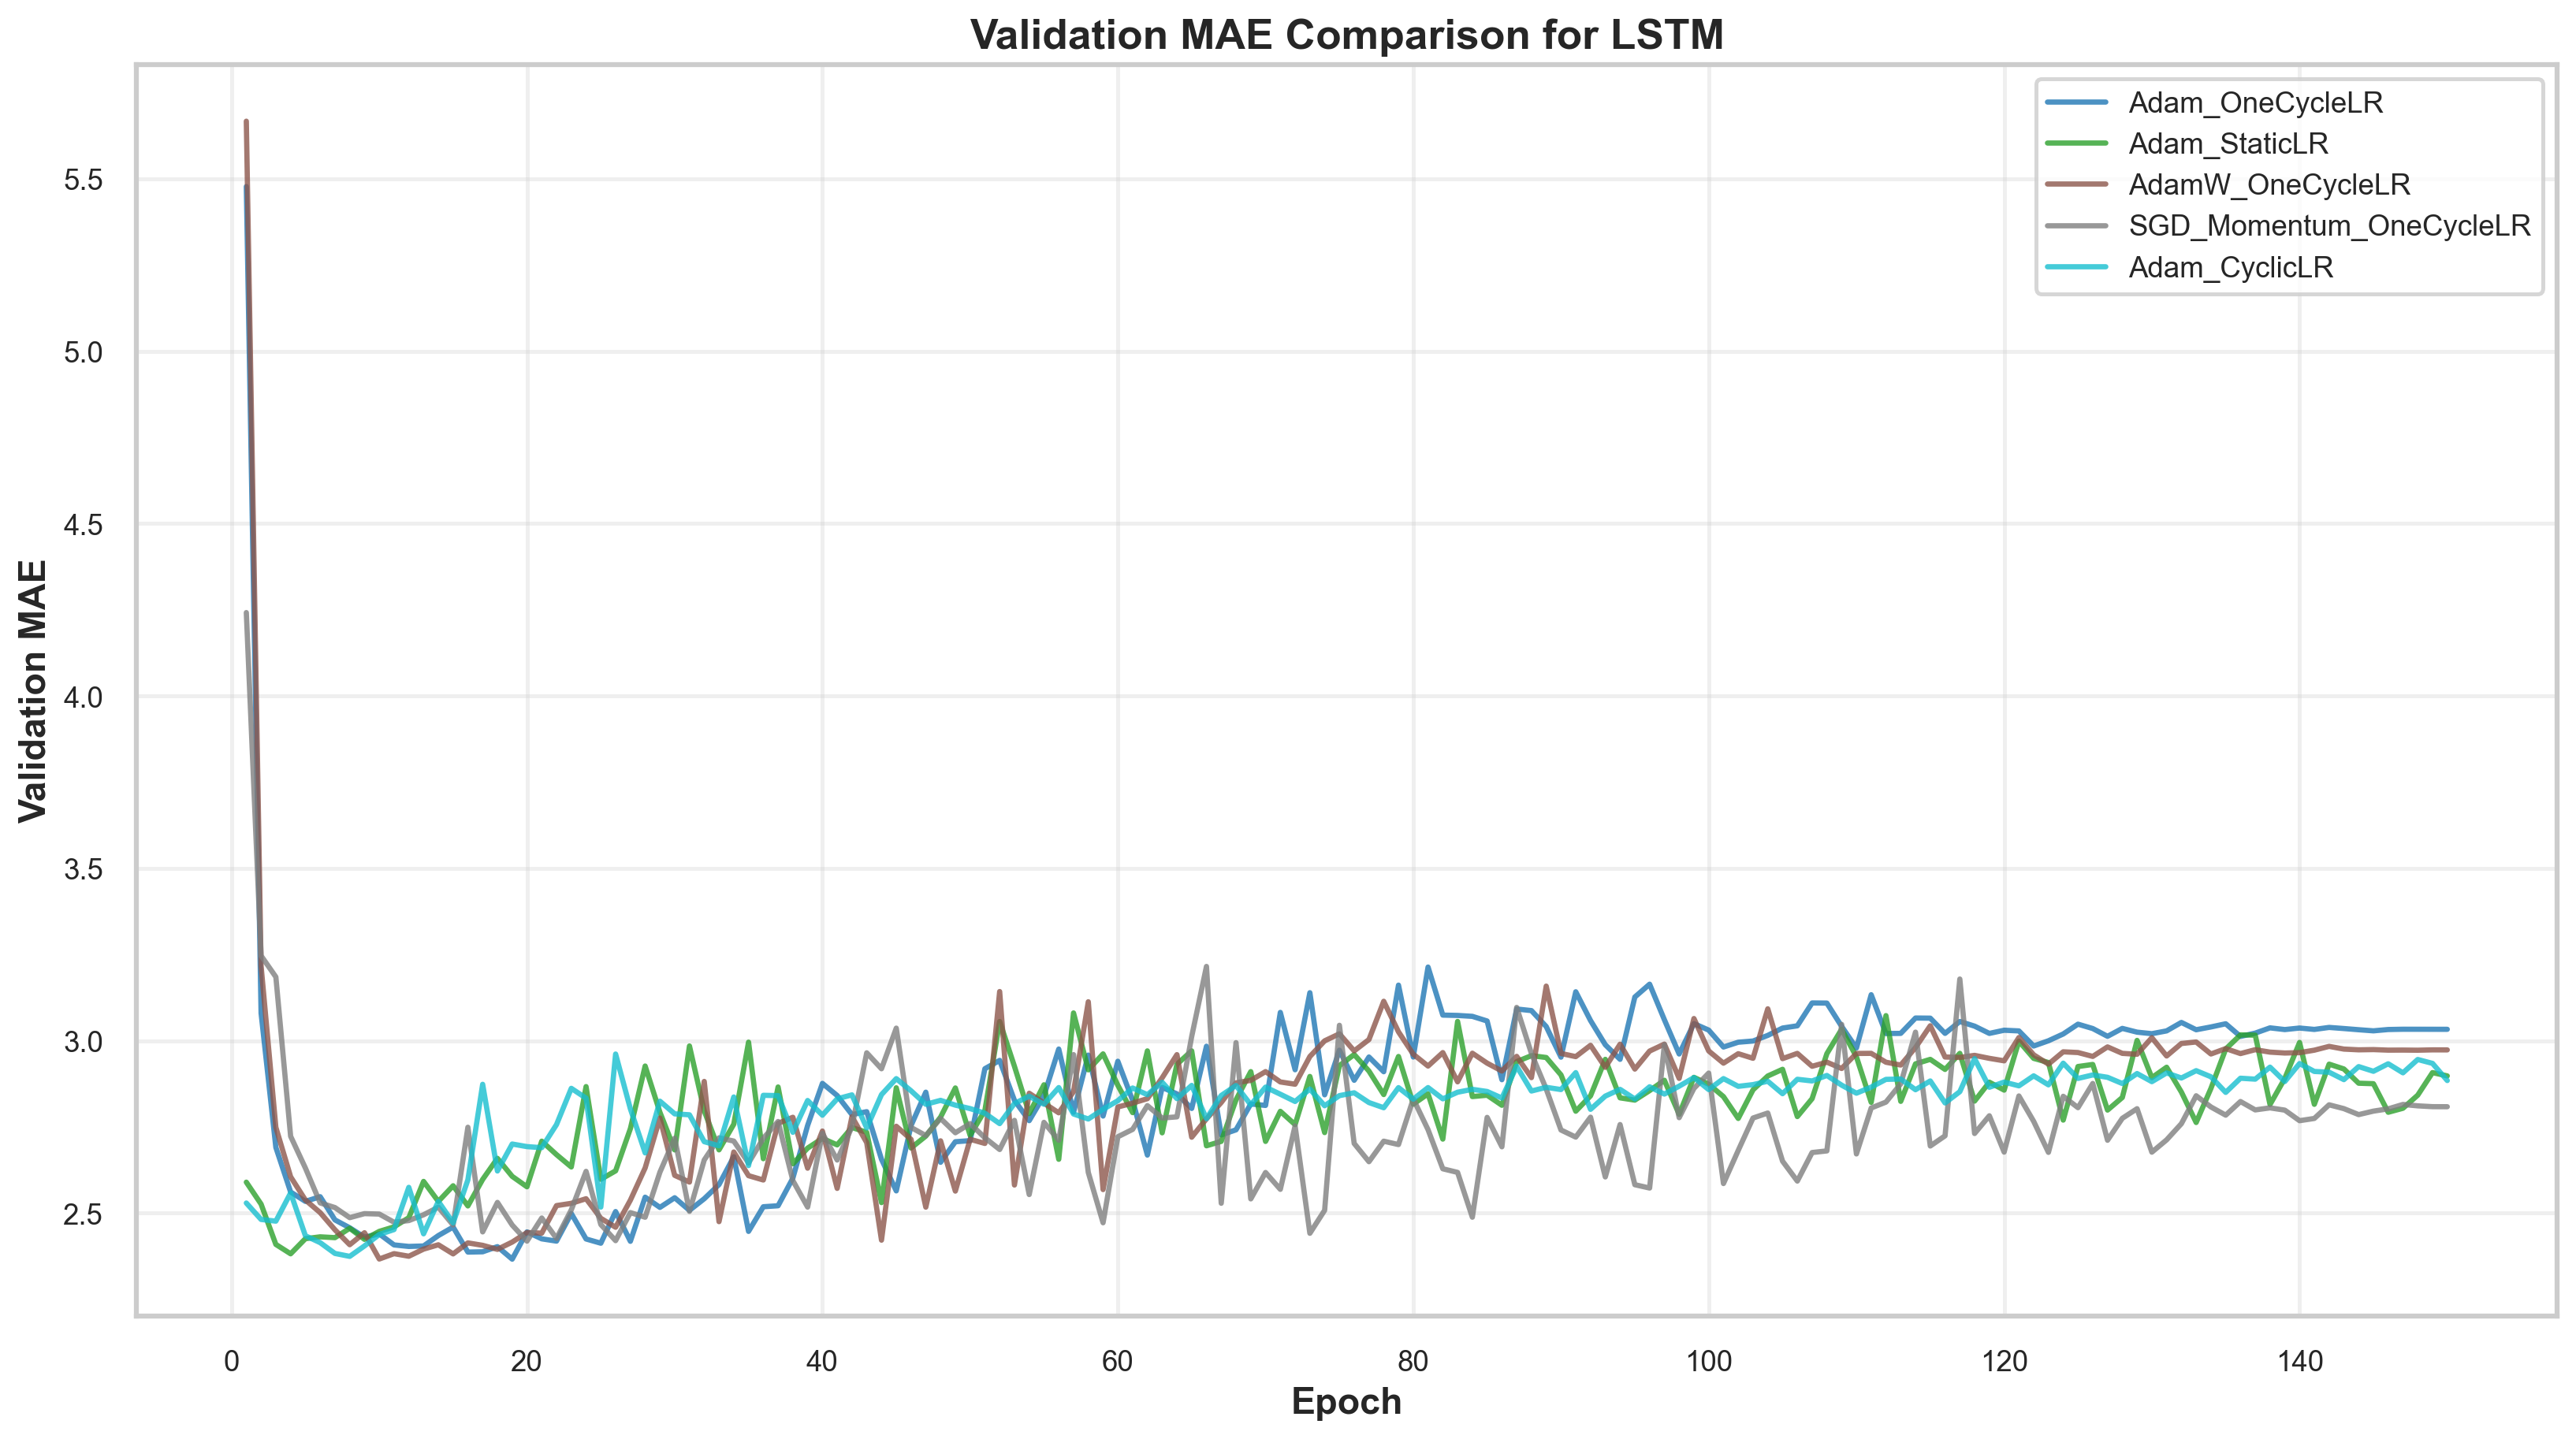


✓ Plot generated for LSTM


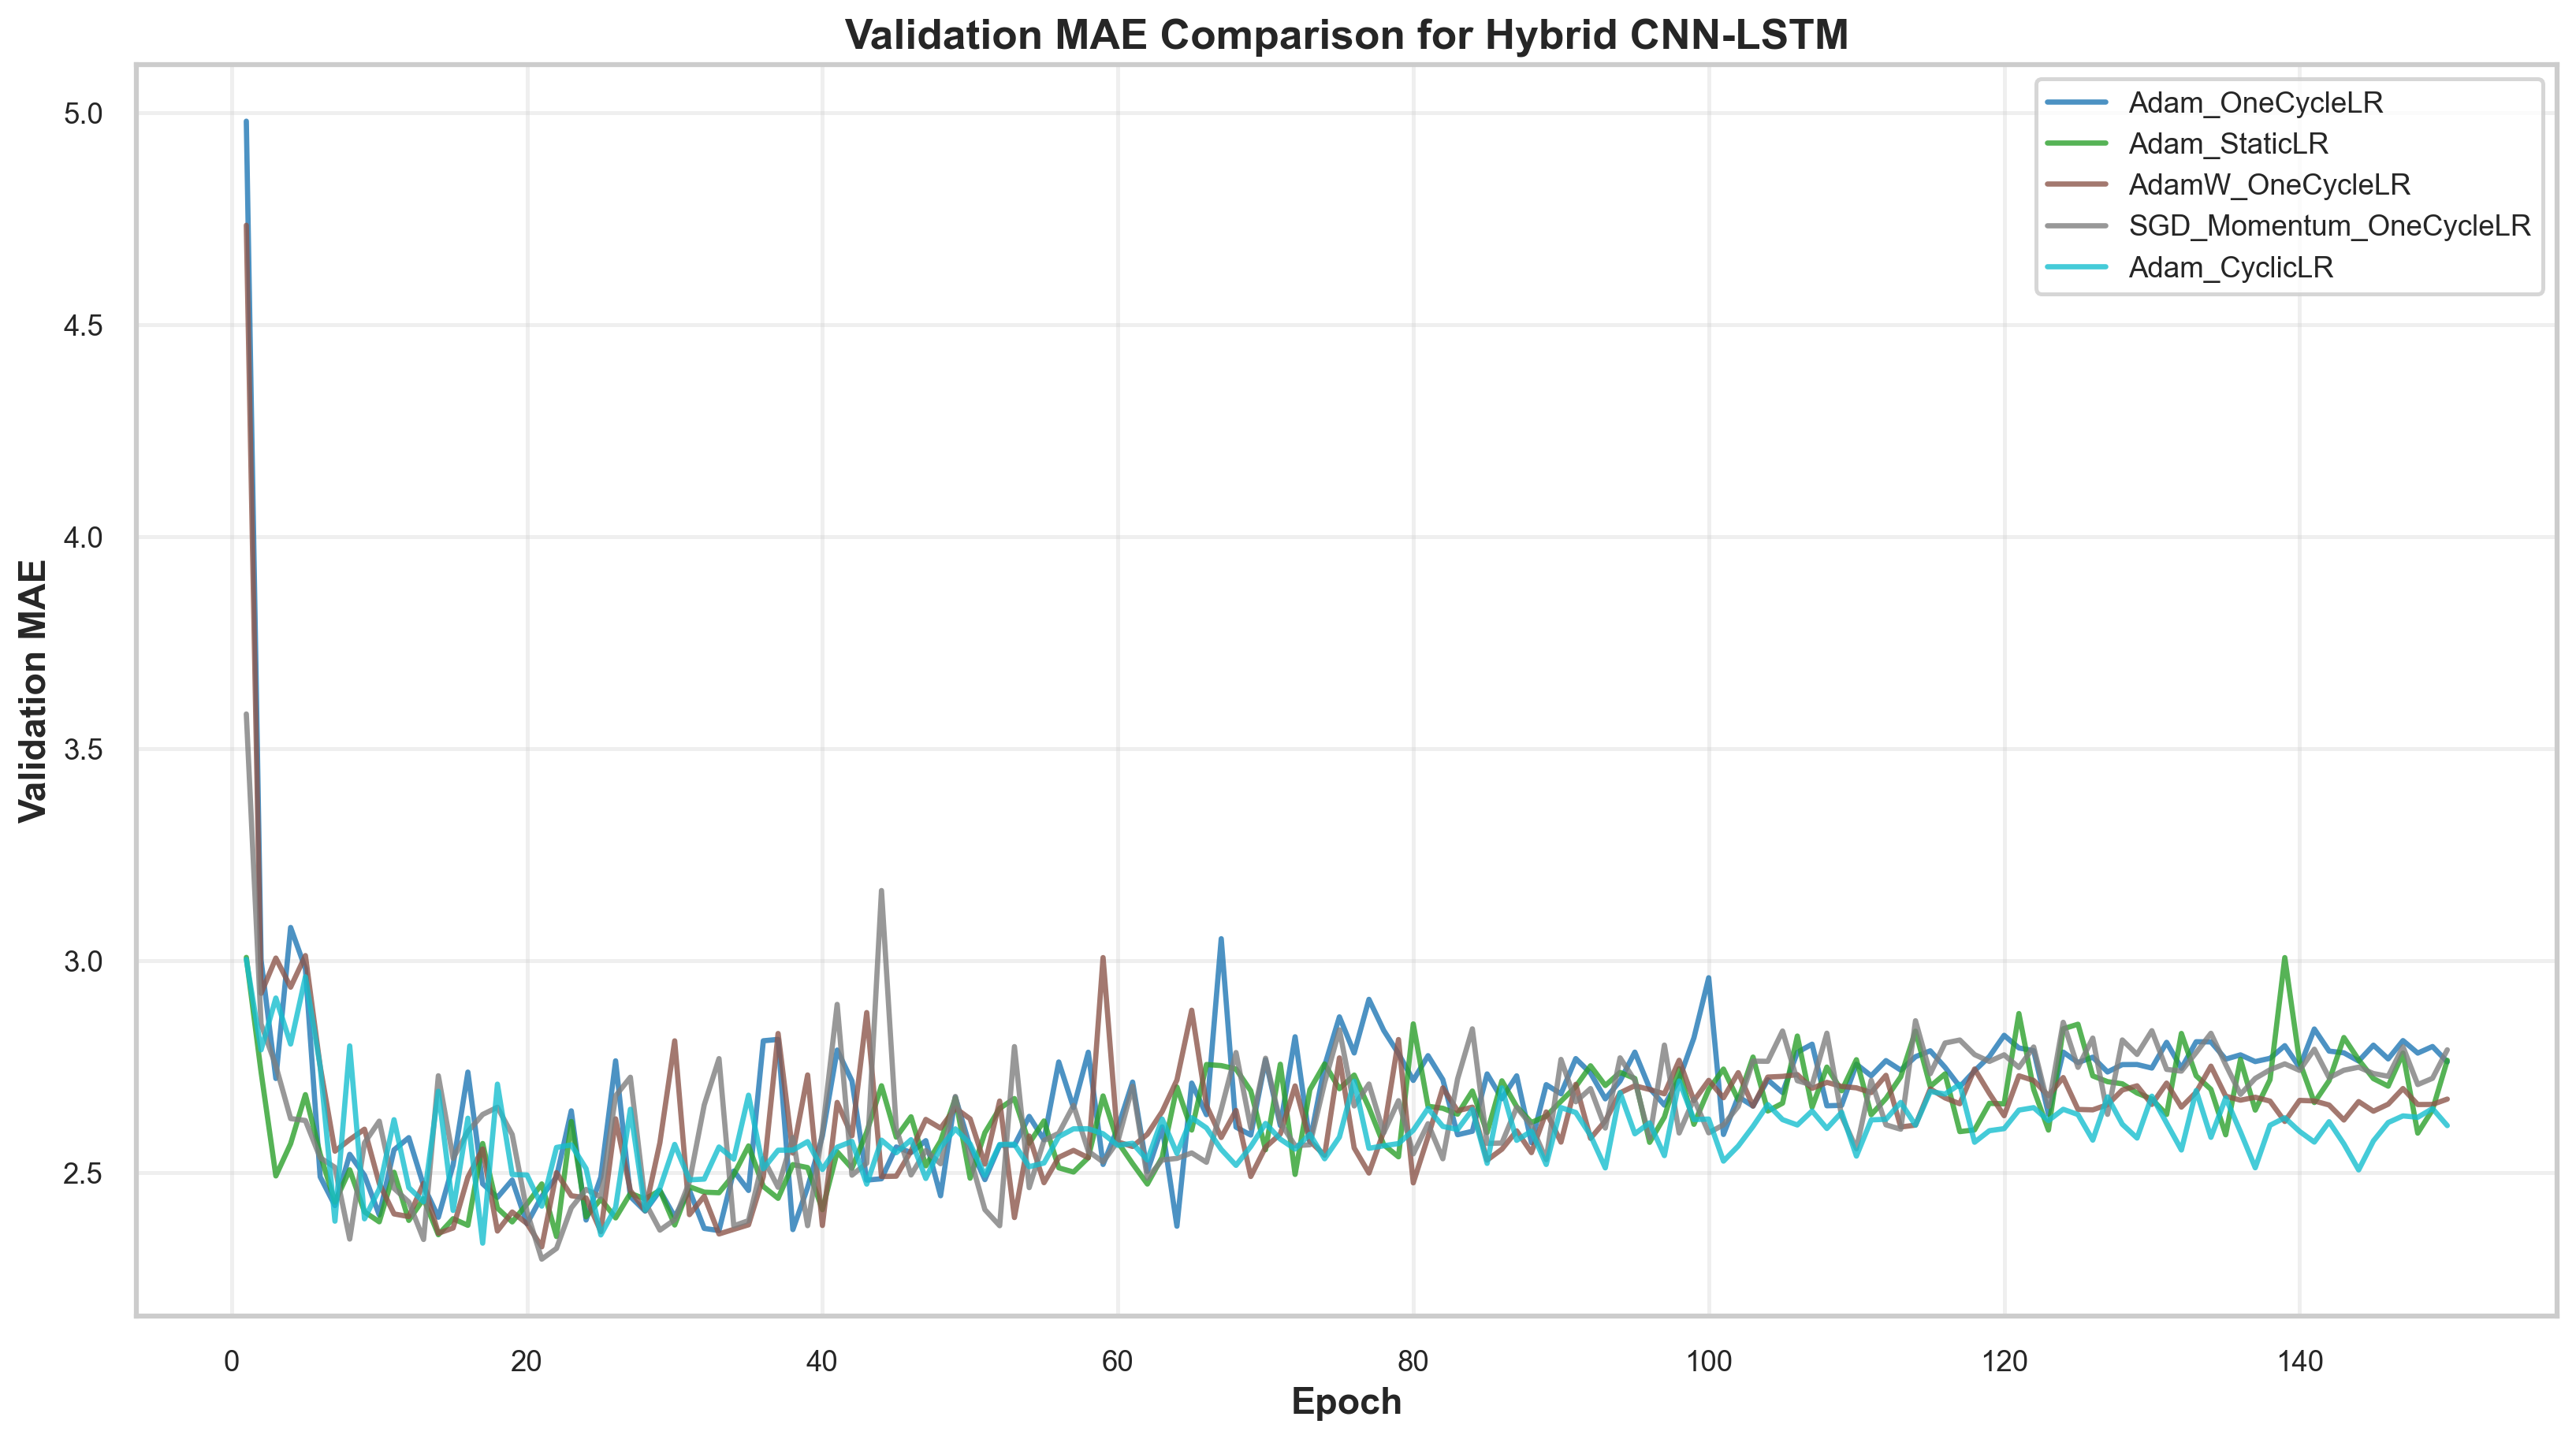


✓ Plot generated for Hybrid CNN-LSTM


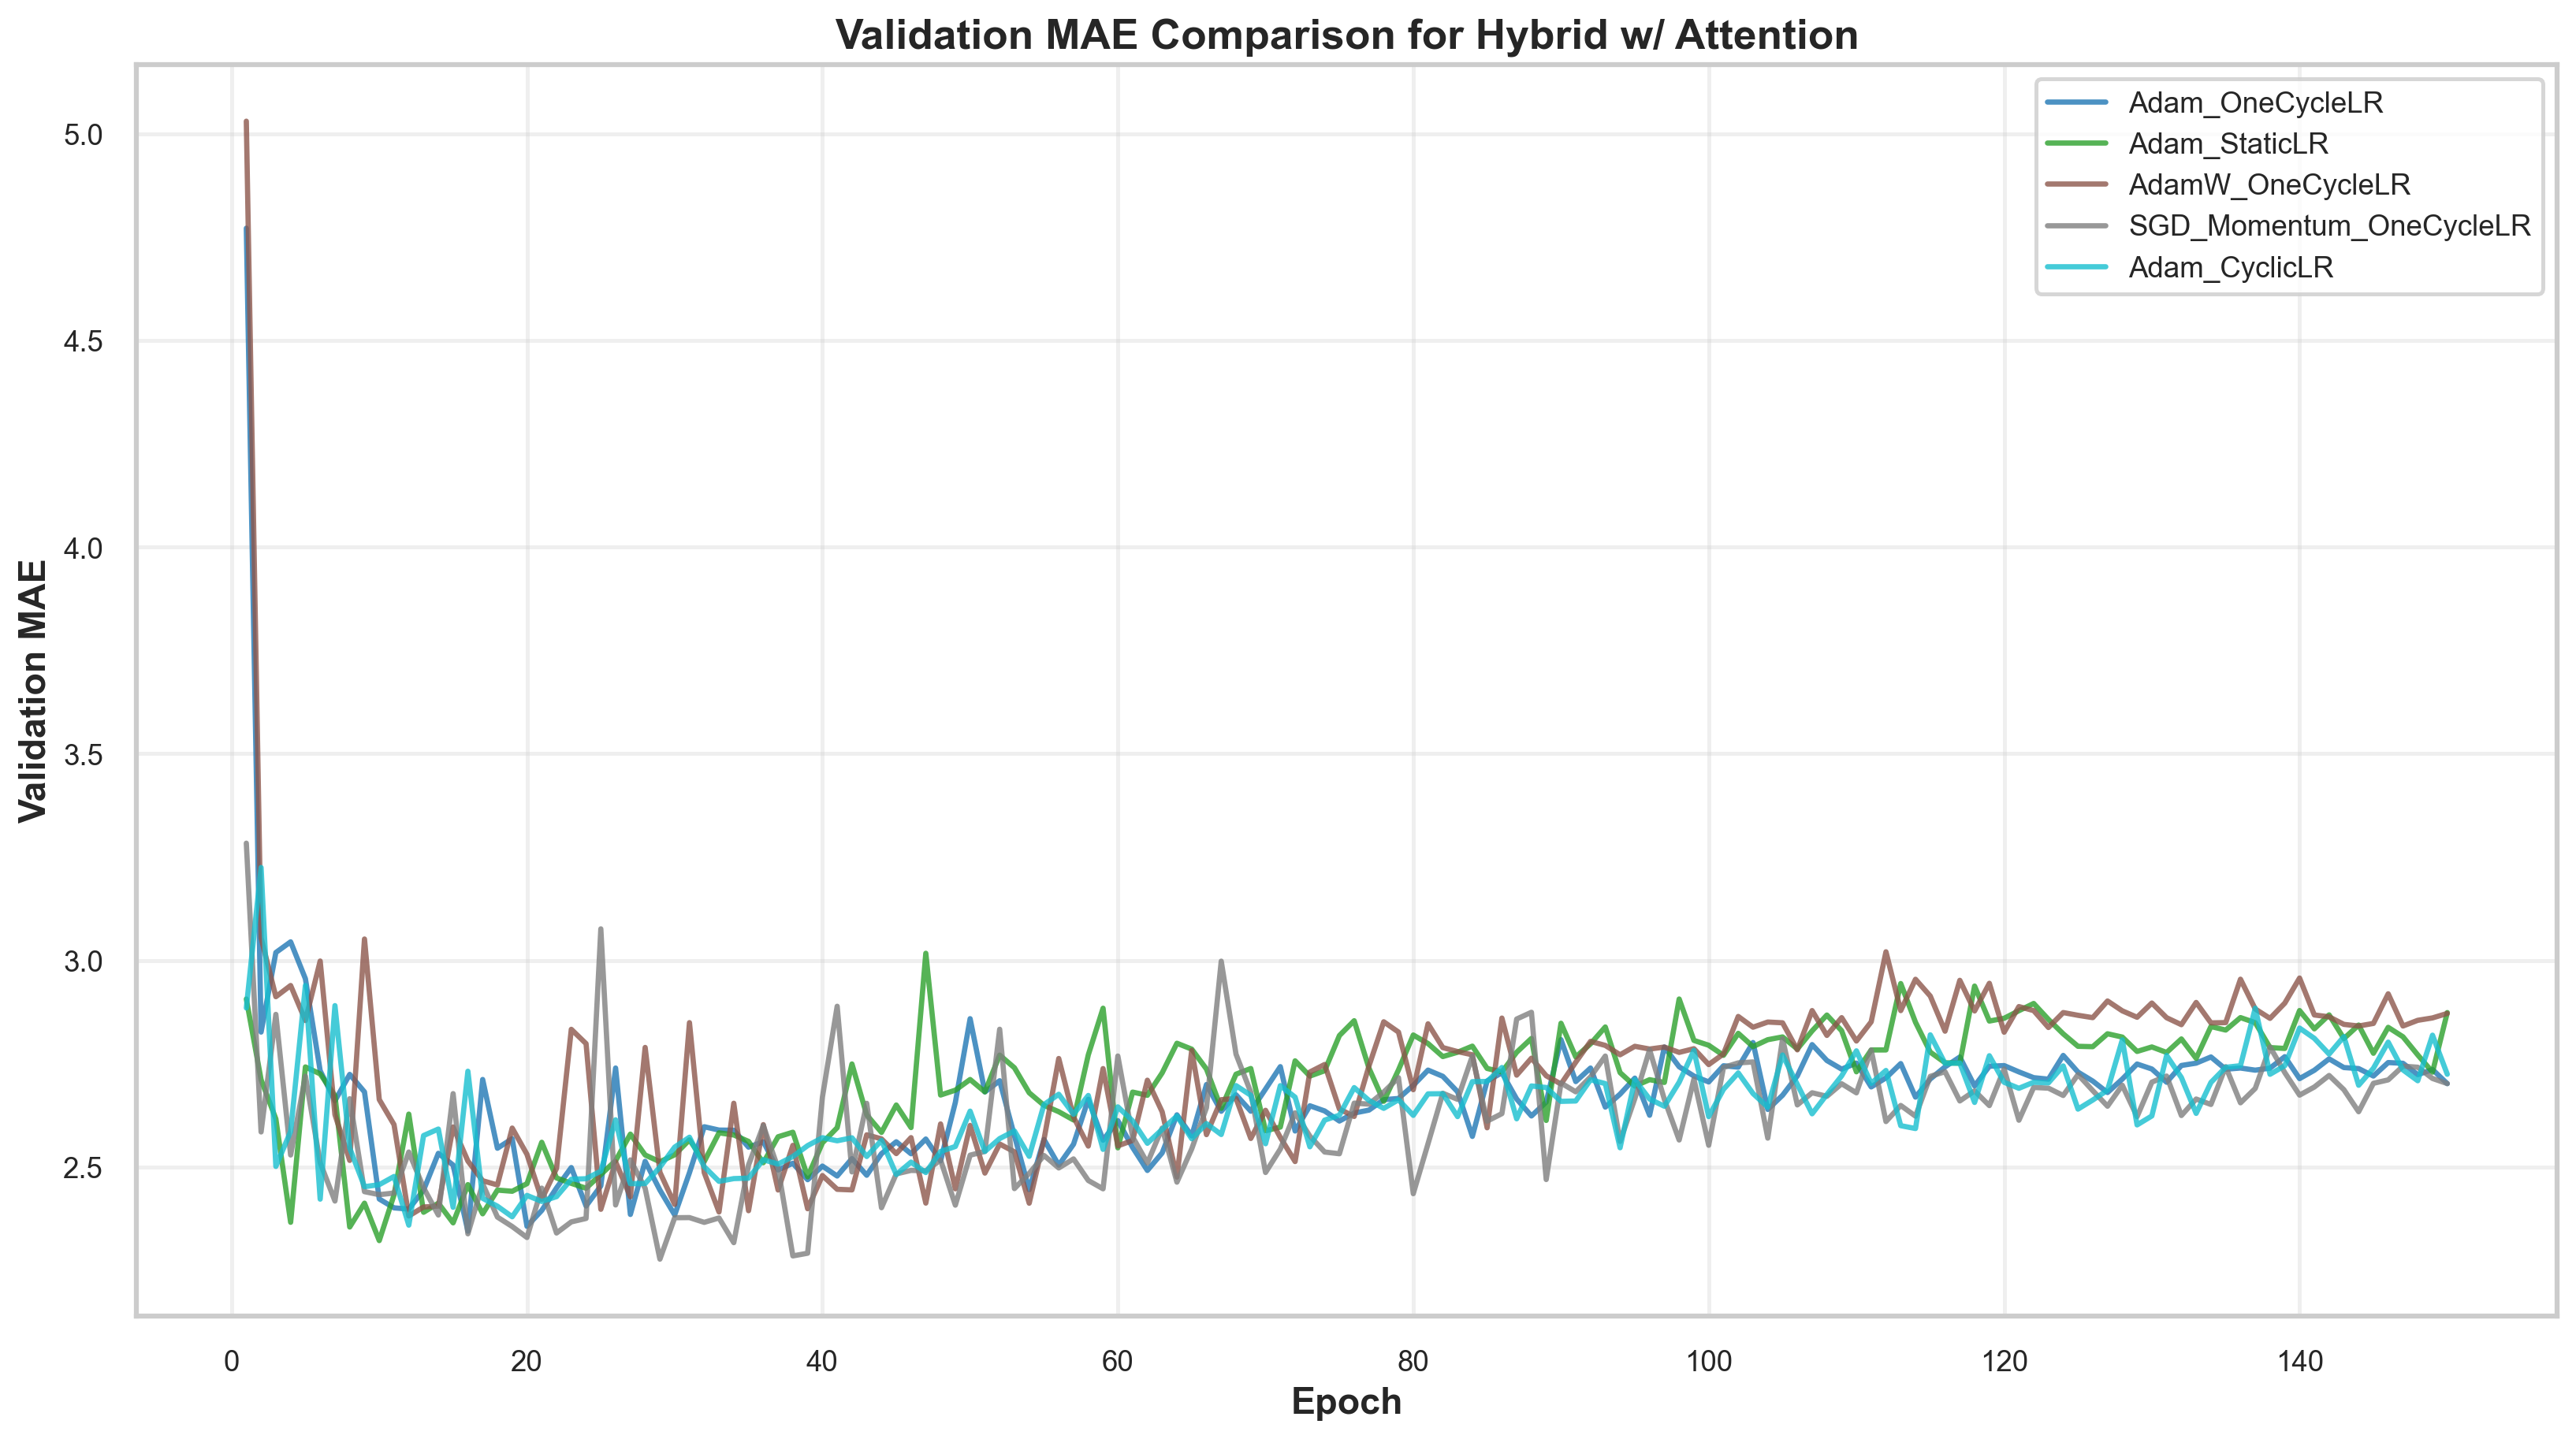


✓ Plot generated for Hybrid w/ Attention


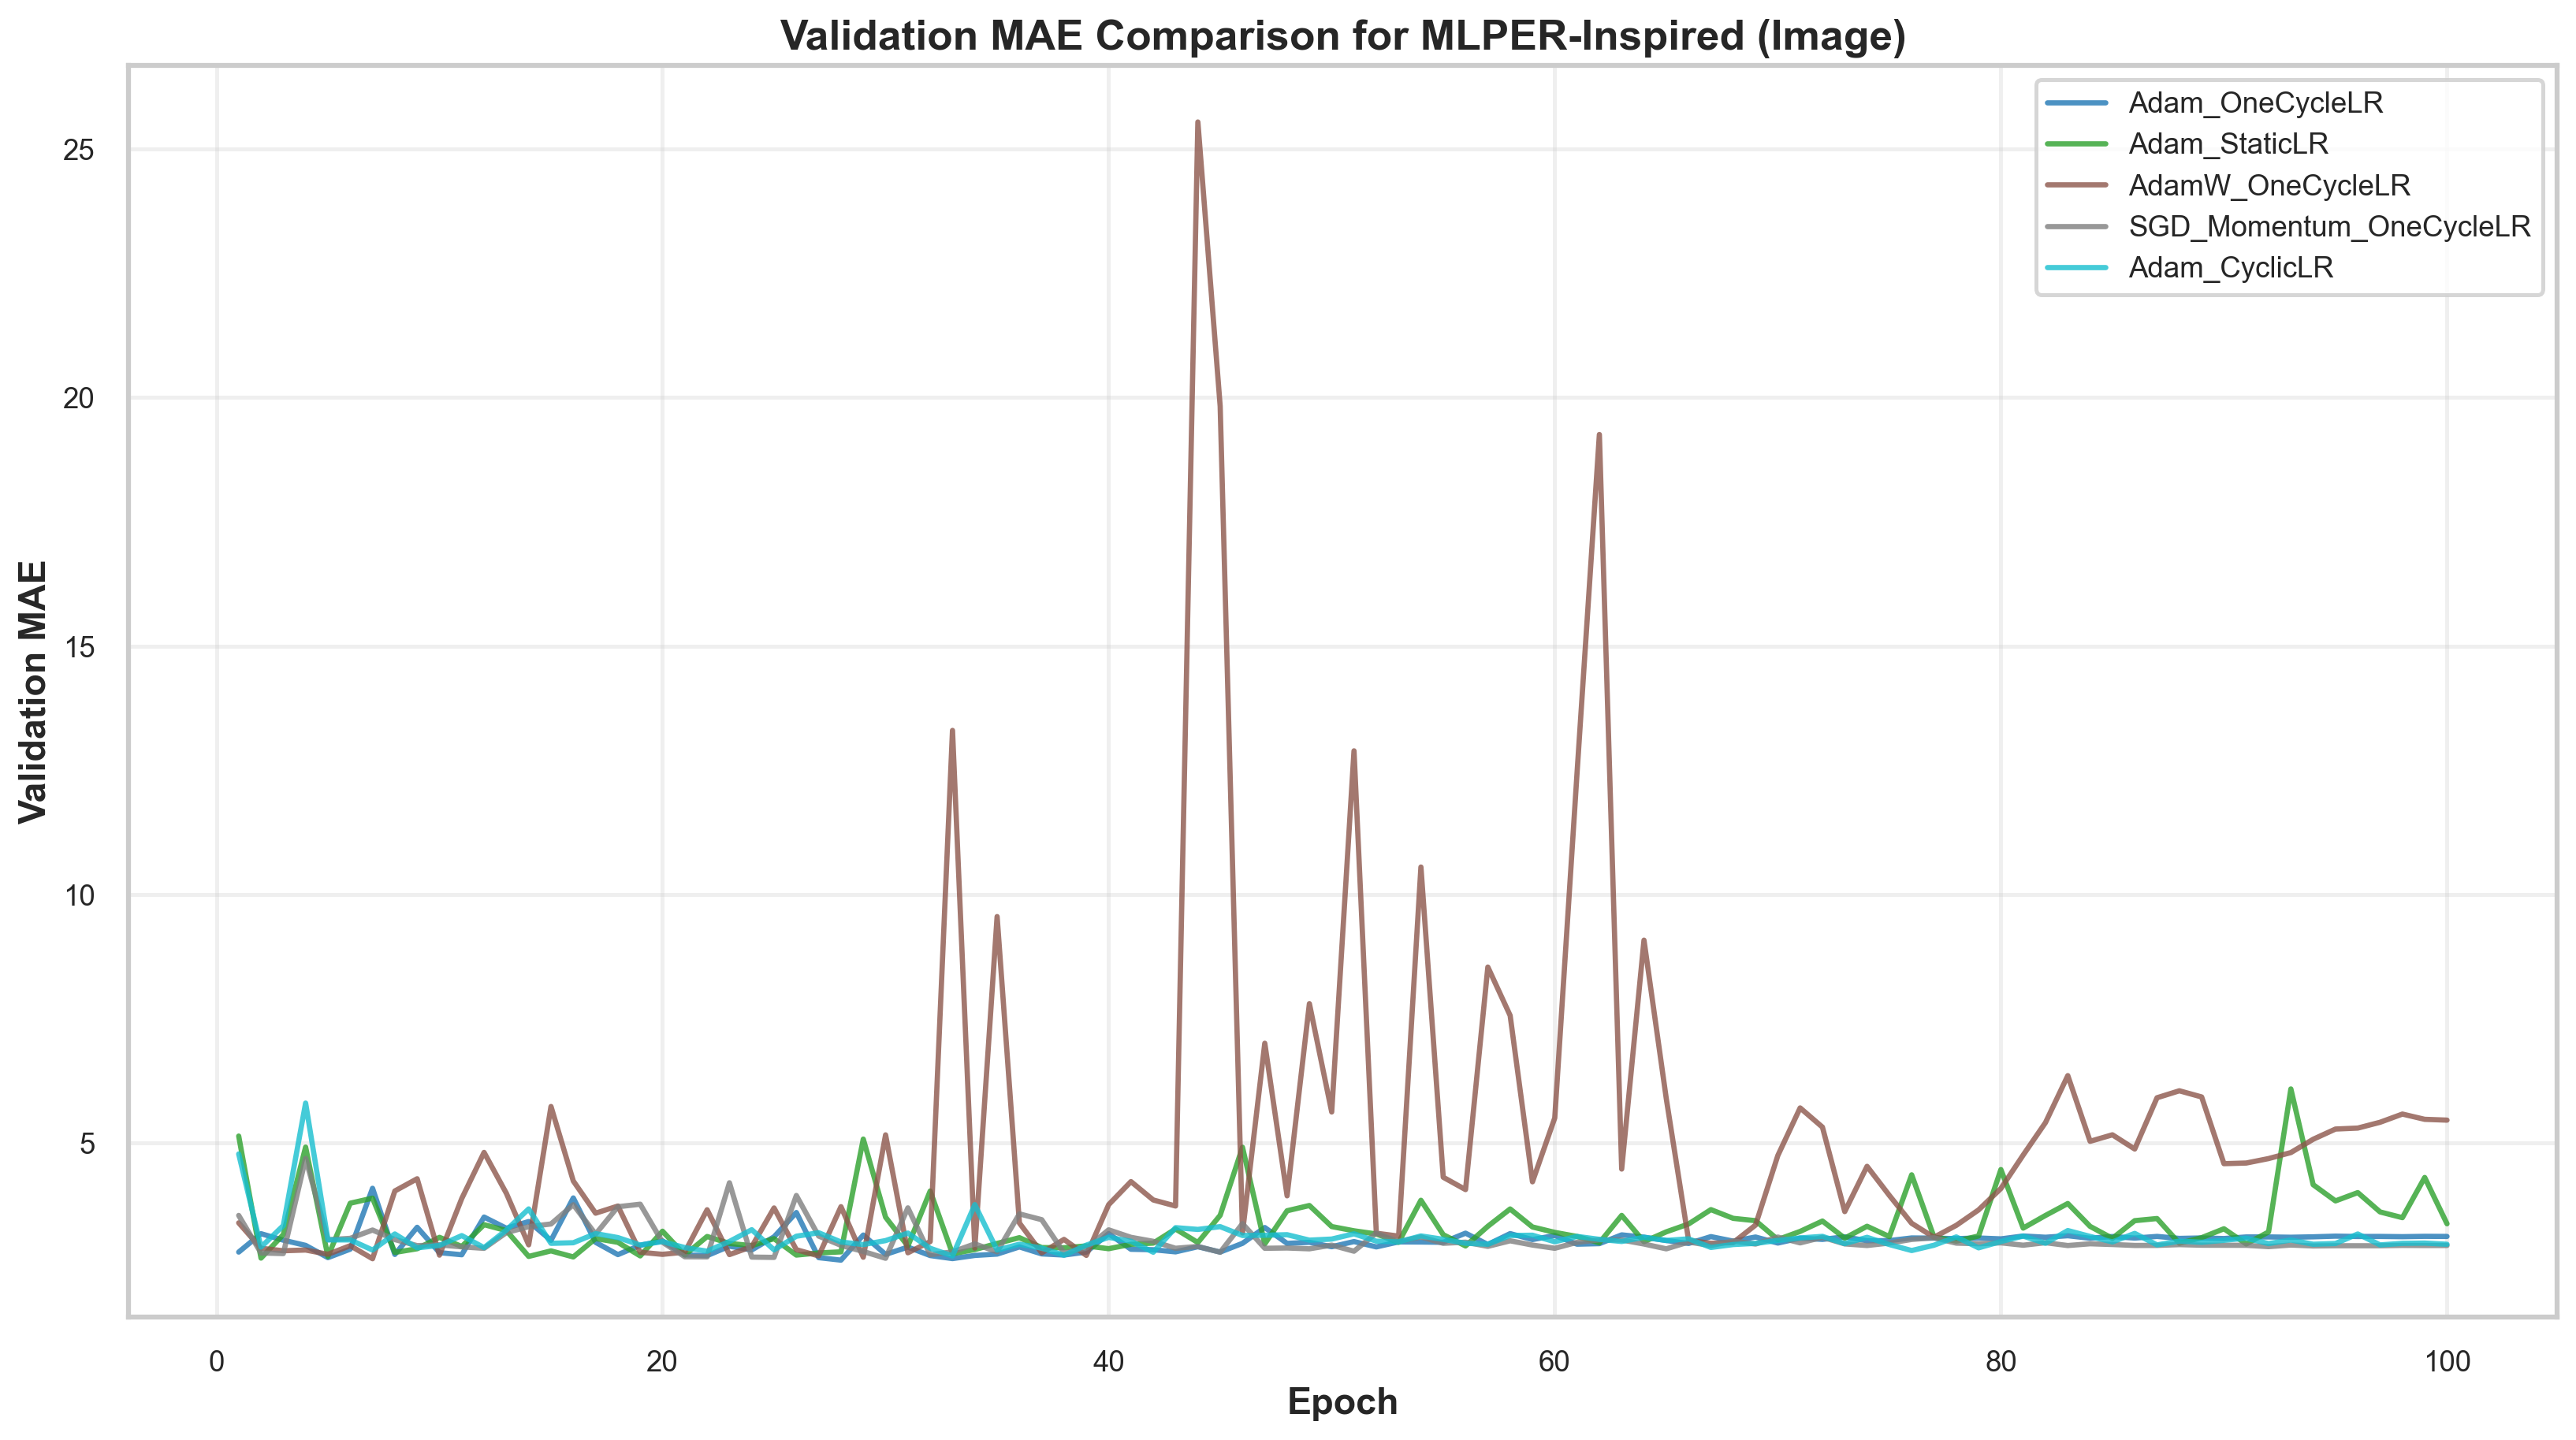


✓ Plot generated for MLPER-Inspired (Image)


In [20]:
# Load the modified training histories with optimizer comparisons
import json

try:
    with open('training_histories.json', 'r') as f:
        histories = json.load(f)
    
    # Get list of unique model names from the top-level keys
    model_names = list(histories.keys())
    print(f"Found {len(model_names)} models: {model_names}")
    
    # Create a separate plot for each model showing all optimizer validation losses
    for model_name in model_names:
        optimizer_results = histories[model_name]
        
        # Create figure for this model
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Plot validation loss for each optimizer
        colors = plt.cm.tab10(np.linspace(0, 1, len(optimizer_results)))
        for (optimizer_name, history), color in zip(optimizer_results.items(), colors):
            epochs = history['epoch']
            val_loss = history['val_loss']
            ax.plot(epochs, val_loss, label=optimizer_name, linewidth=2, alpha=0.8, color=color)
        
        # Set plot properties
        ax.set_xlabel('Epoch', fontsize=14, fontweight='bold')
        ax.set_ylabel('Validation MAE', fontsize=14, fontweight='bold')
        ax.set_title(f'Validation MAE Comparison for {model_name}', fontsize=16, fontweight='bold')
        ax.legend(fontsize=11, loc='best')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"\n✓ Plot generated for {model_name}")
    
except FileNotFoundError:
    print("training_histories.json not found. Please run 'python experiment.py' first.")
except Exception as e:
    print(f"Error loading training histories: {e}")
    import traceback
    traceback.print_exc()


## 7. Conclusion

This project conducted a comprehensive optimizer comparison experiment to identify the best model-optimizer combinations for earthquake time-to-failure prediction. The experiment evaluated multiple deep learning architectures (1D CNN, LSTM, Hybrid CNN-LSTM, and Hybrid with Attention) across various optimizer configurations (Adam, AdamW, SGD with different learning rate schedules).

**Key Findings:**

1. **Optimizer Selection Matters:** Different optimizers and learning rate schedules significantly impact model performance, with some combinations achieving substantially better validation MAE than others.

2. **Model-Optimizer Synergy:** The best-performing model-optimizer combination varies, demonstrating that architecture and optimization strategy must be considered together rather than independently.

3. **Systematic Evaluation:** By training all models with all optimizer configurations and tracking validation performance, we identified the optimal combination that minimizes validation MAE.

4. **Reproducible Workflow:** The experiment results are stored in `training_histories.json`, enabling reproducible analysis and dynamic identification of the best performers without requiring re-training.

The systematic optimizer comparison approach provides a robust methodology for selecting the best model configuration for this complex time-series regression task.
